# Documentation

**Calculate Summer Anomalies from CMIP6 Data** 

**Spencer Ressel & Pedro Angulo Umaña**

April 4th, 2023

This notebook analyzes data from the Detection and Attribution Model Intercomparison Project (DAMIP): https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/cmip6-endorsed-mips-article/1062-modelling-cmip6-damip

Specifically, daily maximum temperature, outgoing longwave radiation (OLR), and sea surface temperatures (SST) are used to study the effects of climate change on heat waves over the Korean peninsula. This work is part of the CATER project.


# Imports

In [116]:
# OS tools
import os
from glob import glob
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeLocator, LatitudeLocator
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import mjo_mean_state_diagnostics as mjo

# Regrid SST data

In [20]:
# # models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
# models_list = ['IPSL-CM6A-LR', 'MIROC6']
# experiments_list = ['historical', 'hist-GHG', 'hist-nat', 'ssp245']
# variable = 'tos'
# for model in models_list:
#     print(model)
#     for experiment in experiments_list:
#         os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/' + experiment)
#         # print(os.getcwd())
        
#         file_list = glob('compiled_tos*.nc')
#         for file in file_list:
#             print(file)
#             # print('cdo -remapbil,r360x180, compiled_tos_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc regridded_test.nc')
#             os.system('cdo -remapbil,r360x180, ' + file + ' regridded_' + (file))
#             # print('cdo -remapbil,r360x180, ' + file + ' regridded_' + (file))
            
# print('finished')

IPSL-CM6A-LR
compiled_tos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_185001-201412.nc
compiled_tos_Omon_IPSL-CM6A-LR_hist-GHG_r1i1p1f1_gn_185001-202012.nc
compiled_tos_Omon_IPSL-CM6A-LR_hist-nat_r1i1p1f1_gn_185001-202012.nc
compiled_tos_Omon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gn_201501-210012.nc
MIROC6
compiled_tos_Omon_MIROC6_historical_r1i1p1f1_gn_185001-201412.nc
compiled_tos_Omon_MIROC6_hist-GHG_r1i1p1f1_gn_185001-202012.nc
compiled_tos_Omon_MIROC6_hist-nat_r1i1p1f1_gn_185001-202012.nc
compiled_tos_Omon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.nc
finished


# Specify models, experiments, and variables

In [339]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
# models_list = ['ACCESS-ESM1-5', 'CanESM5', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['historical', 'hist-nat', 'hist-GHG']

# Specify reference period
reference_period = dict(year=slice(1970,1990))

# Define korea peninsula for land data
korean_peninsula = dict(lat=slice(34, 38), lon=slice(125, 130))

# Define area for SST data
korea_west = 117.5
korea_east = 135
korea_south = 30
korea_north = 42.5

korea_sst_region = dict(lat=slice(30, 42.5), lon=slice(117.5, 135))

# Surface Temperature

## Calculate T-2m anomalies relative to historical experiment

In [12]:
models_list = ['ACCESS-CM2', 'BCC-CSM2-MR', 'NorESM2-LM']
variable = 'tasmax'
for model in models_list:
    
    ################### historical ###################
    # Load the historical data
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model)

    # Load the data
    file_name_historical = sorted(glob('./historical/compiled_' + variable + '_*.nc'))[0]
    [
        variable_historical, 
        frequency_historical, 
        model_name_historical, 
        experiment_historical, 
        variant_historical, 
        grid_historical, 
        period_historical
    ] = file_name_historical.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_historical = xr.open_dataset(file_name_historical)[variable]
    
    
    ################### ssp245 ###################
    # Load the ssp245 data
    file_name_ssp = sorted(glob('./ssp245/compiled_' + variable + '_*.nc'))[0]
    [
        variable_ssp, 
        frequency_ssp, 
        model_name_ssp, 
        experiment_ssp, 
        variant_ssp, 
        grid_ssp, 
        period_ssp
    ] = file_name_ssp.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_ssp = xr.open_dataset(file_name_ssp)[variable]
    
    # Concatenate together the historical data and the ssp data
    # temperature_data_extended = xr.concat((temperature_data_historical, temperature_data_ssp), dim='time')
    period_extended = period_historical.split('-')[0] + '-' + period_ssp.split('-')[-1]
    
    ################### hist-GHG ###################
    # Set the directory
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/hist-GHG/')

    # Load the data
    file_name = sorted(glob('./compiled_*' + variable + '_*.nc'))[0]
    [
    variable_hist_GHG, 
    frequency_hist_GHG, 
    model_name_hist_GHG, 
    experiment_hist_GHG, 
    variant_hist_GHG, 
    grid_hist_GHG, 
    period_hist_GHG
] = file_name.split('/')[-1].split('.nc')[0].split('_')[1:]
    temperature_data_hist_GHG = xr.open_dataset(file_name)[variable]
    
    
    ################### hist-nat ###################
    # Set the directory
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/hist-nat/')

    # Load the data
    file_name = sorted(glob('./compiled_*' + variable + '_*.nc'))[0]
    [
    variable_hist_nat, 
    frequency_hist_nat, 
    model_name_hist_nat, 
    experiment_hist_nat, 
    variant_hist_nat, 
    grid_hist_nat, 
    period_hist_nat
] = file_name.split('/')[-1].split('.nc')[0].split('_')[1:]
    temperature_data_hist_nat = xr.open_dataset(file_name)[variable]
    
    
    # Subset the data to fit the Korean peninsula 
    daily_maximum_temperature_korea_historical = temperature_data_historical.sel(
        korean_peninsula
    ).mean(dim=['lat', 'lon'])
    daily_maximum_temperature_korea_ssp = temperature_data_ssp.sel(
        korean_peninsula
    ).mean(dim=['lat', 'lon'])
    
    daily_maximum_temperature_korea_hist_GHG = temperature_data_hist_GHG.sel(
        korean_peninsula
    ).mean(dim=['lat', 'lon'])
    daily_maximum_temperature_korea_hist_nat = temperature_data_hist_nat.sel(
        korean_peninsula
    ).mean(dim=['lat', 'lon'])

    # Compute the mean summer temperature for each year
    summer_mean_max_temperature_by_year_historical = daily_maximum_temperature_korea_historical.sel(
        time=daily_maximum_temperature_korea_historical['time.month'].isin([7,8])
    ).groupby('time.year').mean()
    summer_mean_max_temperature_by_year_ssp = daily_maximum_temperature_korea_ssp.sel(
        time=daily_maximum_temperature_korea_ssp['time.month'].isin([7,8])
    ).groupby('time.year').mean()
    summer_mean_max_temperature_by_year_hist_GHG = daily_maximum_temperature_korea_hist_GHG.sel(
        time=daily_maximum_temperature_korea_hist_GHG['time.month'].isin([7,8])
    ).groupby('time.year').mean()
    summer_mean_max_temperature_by_year_hist_nat = daily_maximum_temperature_korea_hist_nat.sel(
        time=daily_maximum_temperature_korea_hist_nat['time.month'].isin([7,8])
    ).groupby('time.year').mean()

    # Compute the mean temperature of the reference period
    reference_period_mean_temperature_historical = summer_mean_max_temperature_by_year_historical.sel(
        reference_period
    ).mean()

    # Compute anomalies from reference period
    summer_temperature_anomalies_historical = (
        summer_mean_max_temperature_by_year_historical 
        - reference_period_mean_temperature_historical
    )
    
    summer_temperature_anomalies_ssp = (
        summer_mean_max_temperature_by_year_ssp 
        - reference_period_mean_temperature_historical
    )
    
    summer_temperature_anomalies_extended  = xr.concat(
        (
            summer_temperature_anomalies_historical, 
            summer_temperature_anomalies_ssp
        ), dim='year'
    )
    
    summer_temperature_anomalies_hist_GHG = (
        summer_mean_max_temperature_by_year_hist_GHG 
        - reference_period_mean_temperature_extended
    )
    summer_temperature_anomalies_hist_nat = (
        summer_mean_max_temperature_by_year_hist_nat 
        - reference_period_mean_temperature_extended
    )

    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model +'/')
    # Create new file to save temperature anomalies
    new_file_name_historical = (
        variable_historical
        + '-extended_anomalies-hist-' 
        + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
        + '_' + frequency_historical 
        + '_' + model
        + '_' + experiment_historical
        + '_' + variant_historical 
        + '_' + grid_historical
        + '_' + period_extended
        + '.nc'
    )

    # Save output to netCDF
    print(new_file_name_historical)
    if not os.path.exists(new_file_name_historical)
    summer_temperature_anomalies_extended.to_netcdf('./historical/' + new_file_name_historical)

    # Create new file to save temperature anomalies
    new_file_name_hist_GHG = (
        variable_hist_GHG
        + '_anomalies-hist-' + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
        + '_' + frequency_hist_GHG 
        + '_' + model
        + '_' + experiment_hist_GHG
        + '_' + variant_hist_GHG 
        + '_' + grid_hist_GHG
        + '_' + period_hist_GHG
        + '.nc'
    )

    # Save output to netCDF
    print(new_file_name_hist_GHG)
    if not os.path.exists(new_file_name_hist_GHG)
    summer_temperature_anomalies_hist_GHG.to_netcdf('./hist-GHG/' + new_file_name_hist_GHG)

    # Create new file to save temperature anomalies
    new_file_name_hist_nat = (
        variable_hist_nat
        + '_anomalies-hist-' + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
        + '_' + frequency_hist_nat 
        + '_' + model
        + '_' + experiment_hist_nat
        + '_' + variant_hist_nat 
        + '_' + grid_hist_nat
        + '_' + period_hist_nat
        + '.nc'
    )

    # Save output to netCDF
    print(new_file_name_hist_nat)
    if not os.path.exists(new_file_name_hist_nat)
    summer_temperature_anomalies_hist_nat.to_netcdf('./hist-nat/' + new_file_name_hist_nat)

tasmax_extended-anomalies-hist-1970-1990_day_CNRM-CM6-1_historical_r1i1p1f2_gr_18500101-21001231.nc
tasmax_anomalies-hist-1970-1990_day_CNRM-CM6-1_hist-GHG_r1i1p1f2_gr_18500101-20201231.nc
tasmax_anomalies-hist-1970-1990_day_CNRM-CM6-1_hist-nat_r1i1p1f2_gr_18500101-20201231.nc
tasmax_extended-anomalies-hist-1970-1990_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-21001230.nc
tasmax_anomalies-hist-1970-1990_day_HadGEM3-GC31-LL_hist-GHG_r1i1p1f3_gn_18500101-20201230.nc
tasmax_anomalies-hist-1970-1990_day_HadGEM3-GC31-LL_hist-nat_r1i1p1f3_gn_18500101-20201230.nc
tasmax_extended-anomalies-hist-1970-1990_day_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-21001231.nc
tasmax_anomalies-hist-1970-1990_day_IPSL-CM6A-LR_hist-GHG_r1i1p1f1_gr_18500101-20201231.nc
tasmax_anomalies-hist-1970-1990_day_IPSL-CM6A-LR_hist-nat_r1i1p1f1_gr_18500101-20201231.nc
tasmax_extended-anomalies-hist-1970-1990_day_MIROC6_historical_r1i1p1f1_gn_18500101-21001231.nc
tasmax_anomalies-hist-1970-1990_day_MIROC6_hist-G

## Calculate Twenty Year Mean

In [6]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['historical', 'hist-GHG', 'hist-nat']
# models_list = ['ACCESS-ESM1-5', 'CanESM5', 'IPSL-CM6A-LR', 'MRI-ESM2-0']

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

twenty_year_mean_temperatures_hist_nat = {}
twenty_year_mean_temperatures_GHG_nat = {}
twenty_year_mean_temperatures_hist_GHG = {}

for model in models_list:
    temperature_anomalies = {}
    for exp in experiments_list:
        
        if exp == 'historical':
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/historical')
            file_name = glob('tasmax-extended_anomalies-hist-1970*.nc')[0]
            [
                variable, 
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tasmax']
        
        else:
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/' + exp)
            file_name = sorted(glob('tasmax_anomalies-hist-1970*.nc'))[0]
            [
                variable, 
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tasmax']

        
    twenty_year_mean_temperatures_hist_nat[model] = (
        temperature_anomalies[model + '_historical'].sel(year=slice(2000, 2020)).mean()
      - temperature_anomalies[model + '_hist-nat'].sel(year=slice(2000, 2020)).mean()
    )
    
    twenty_year_mean_temperatures_GHG_nat[model] = (
        temperature_anomalies[model + '_hist-GHG'].sel(year=slice(2000, 2020)).mean()
      - temperature_anomalies[model + '_hist-nat'].sel(year=slice(2000, 2020)).mean()
    )
    
    twenty_year_mean_temperatures_hist_GHG[model] = (
        temperature_anomalies[model + '_historical'].sel(year=slice(2000, 2020)).mean()
      - temperature_anomalies[model + '_hist-GHG'].sel(year=slice(2000, 2020)).mean()
    )

## Plot temperature anomalies over time

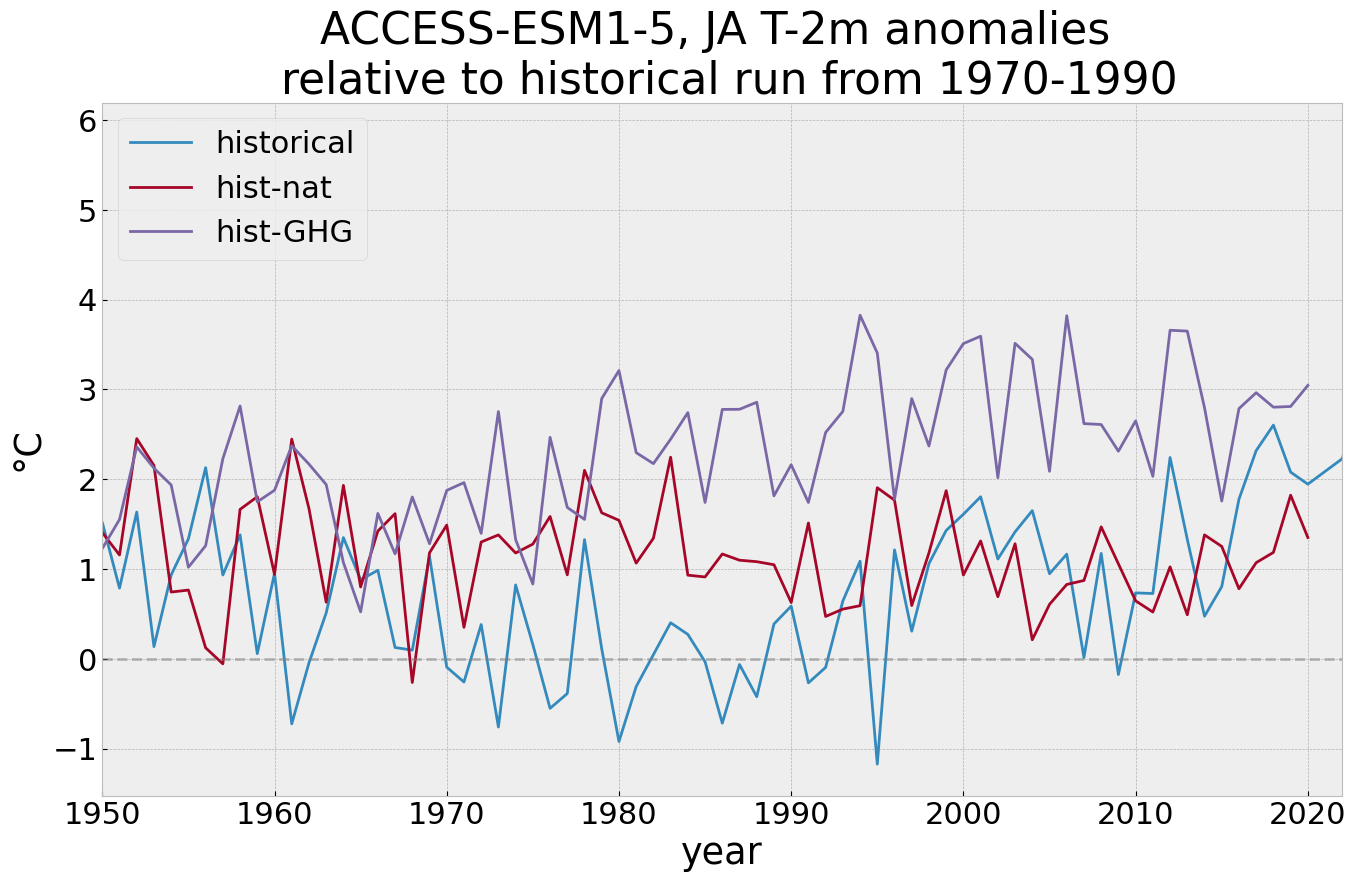

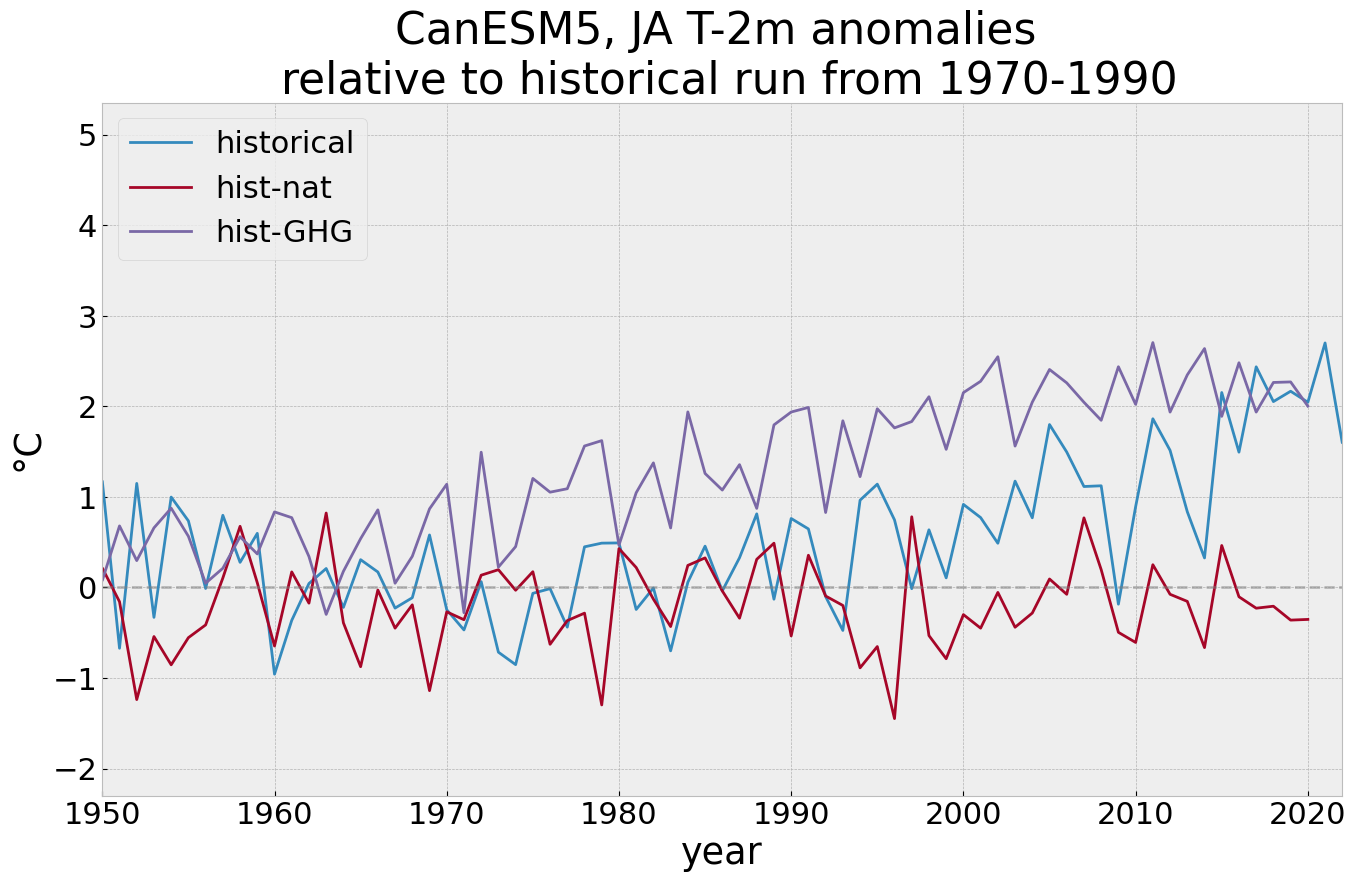

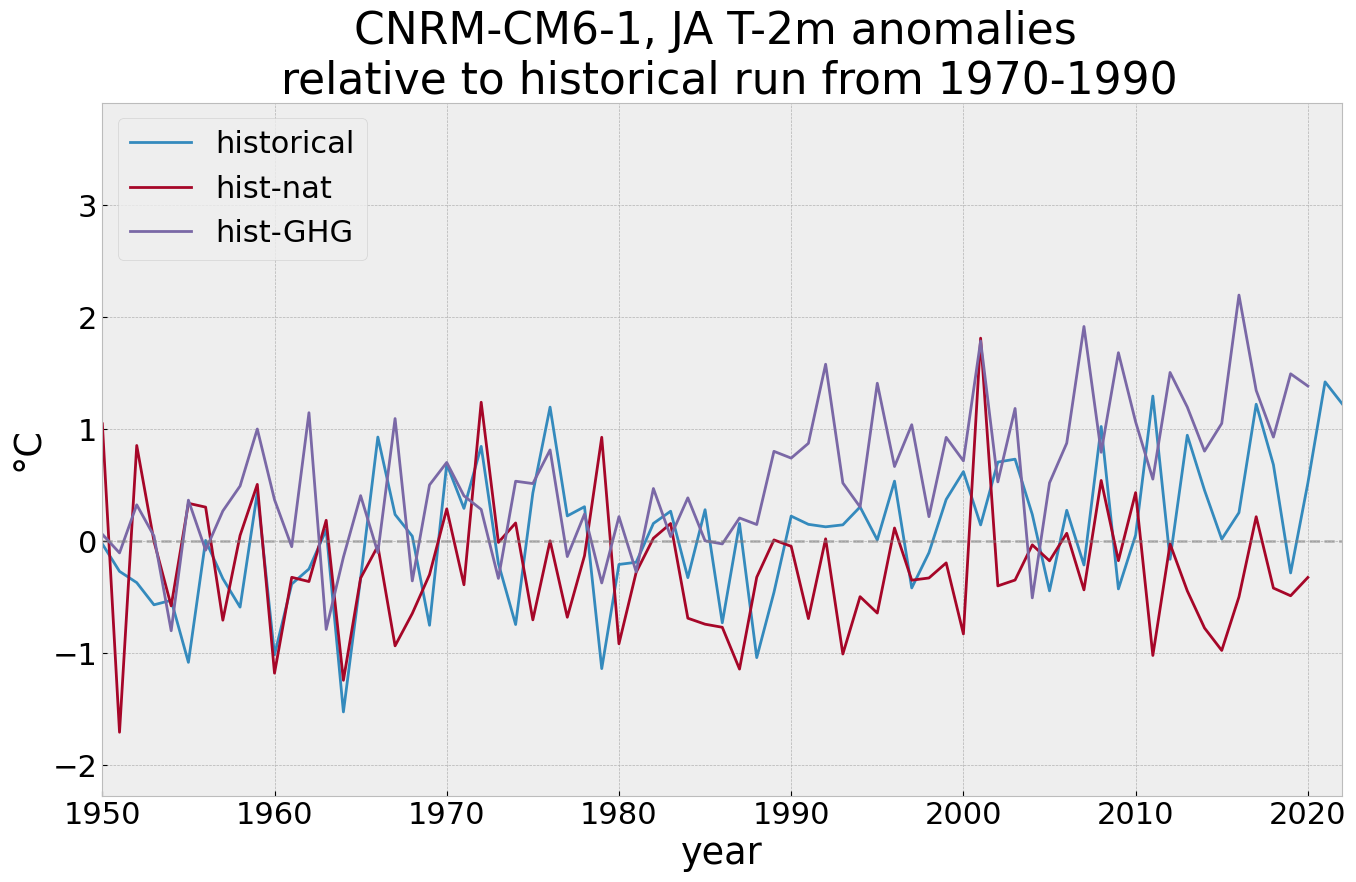

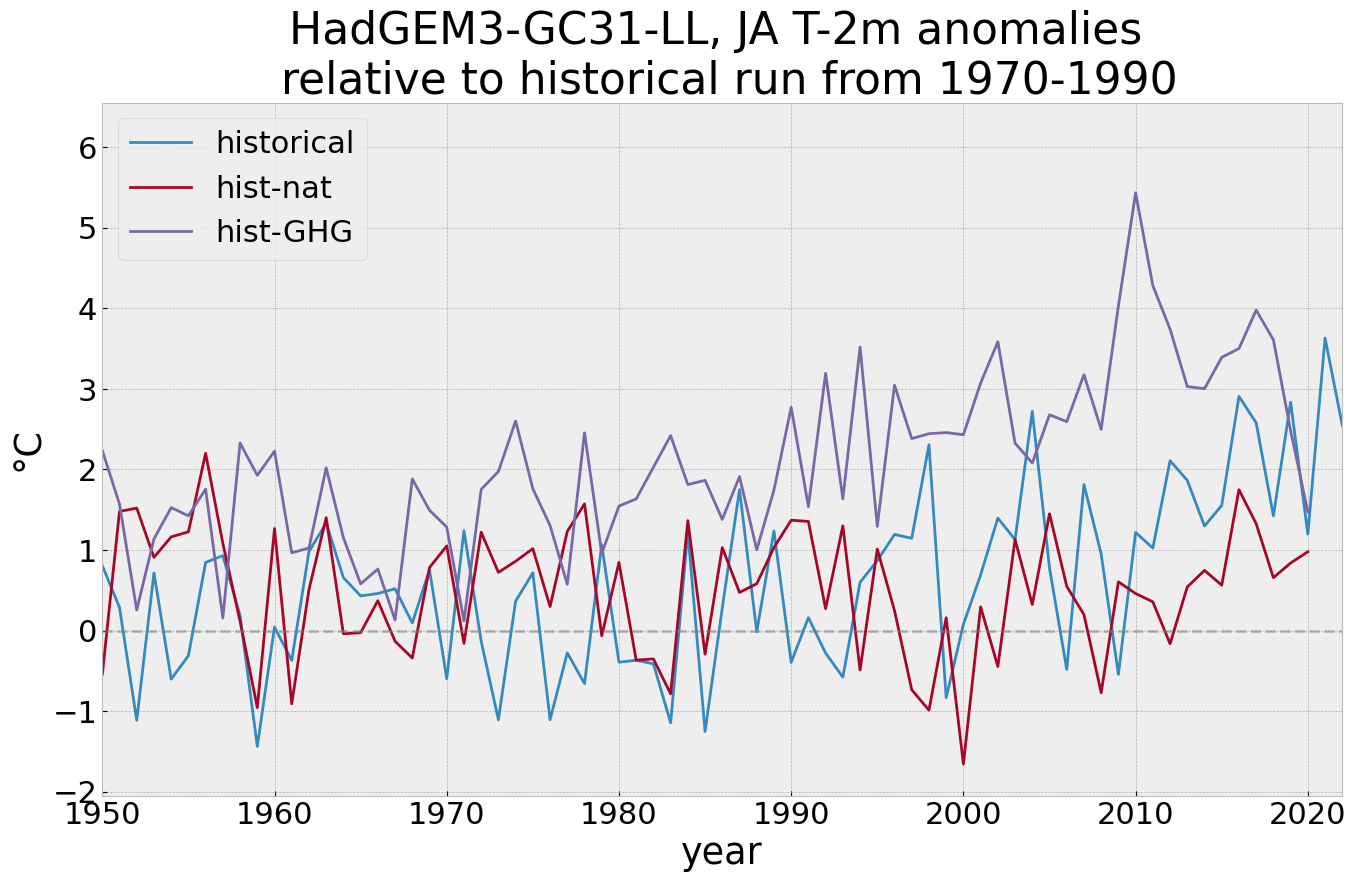

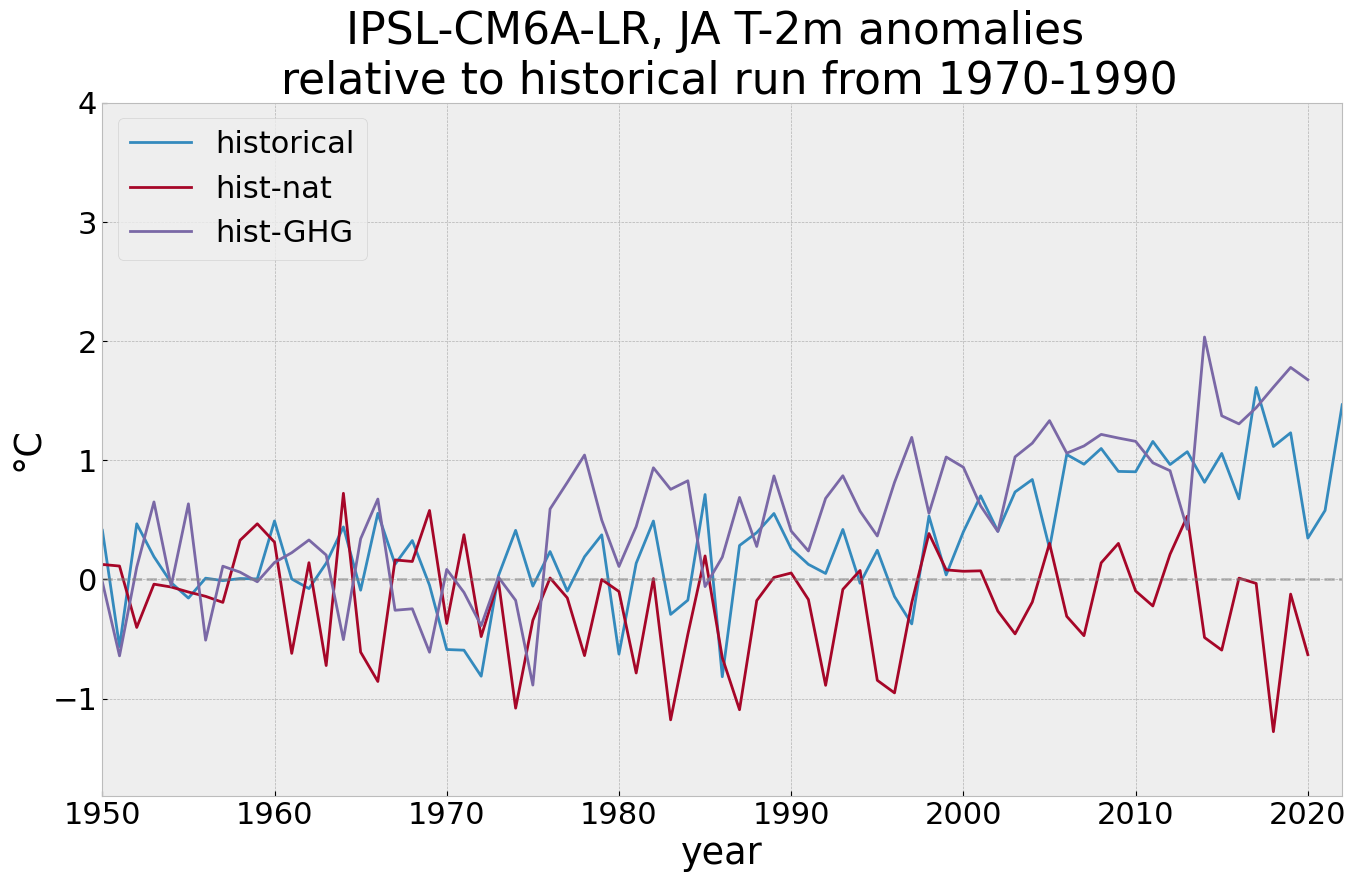

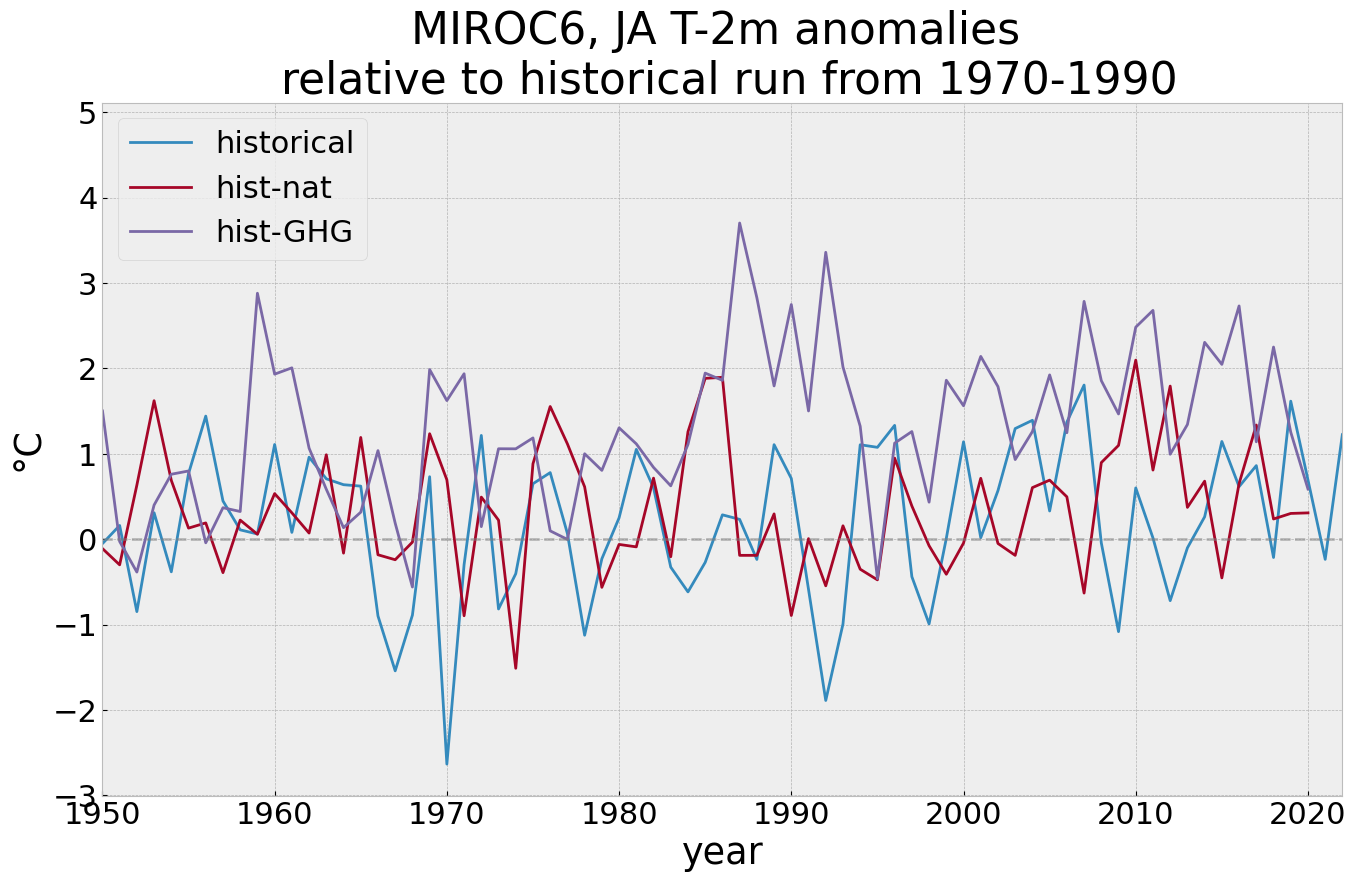

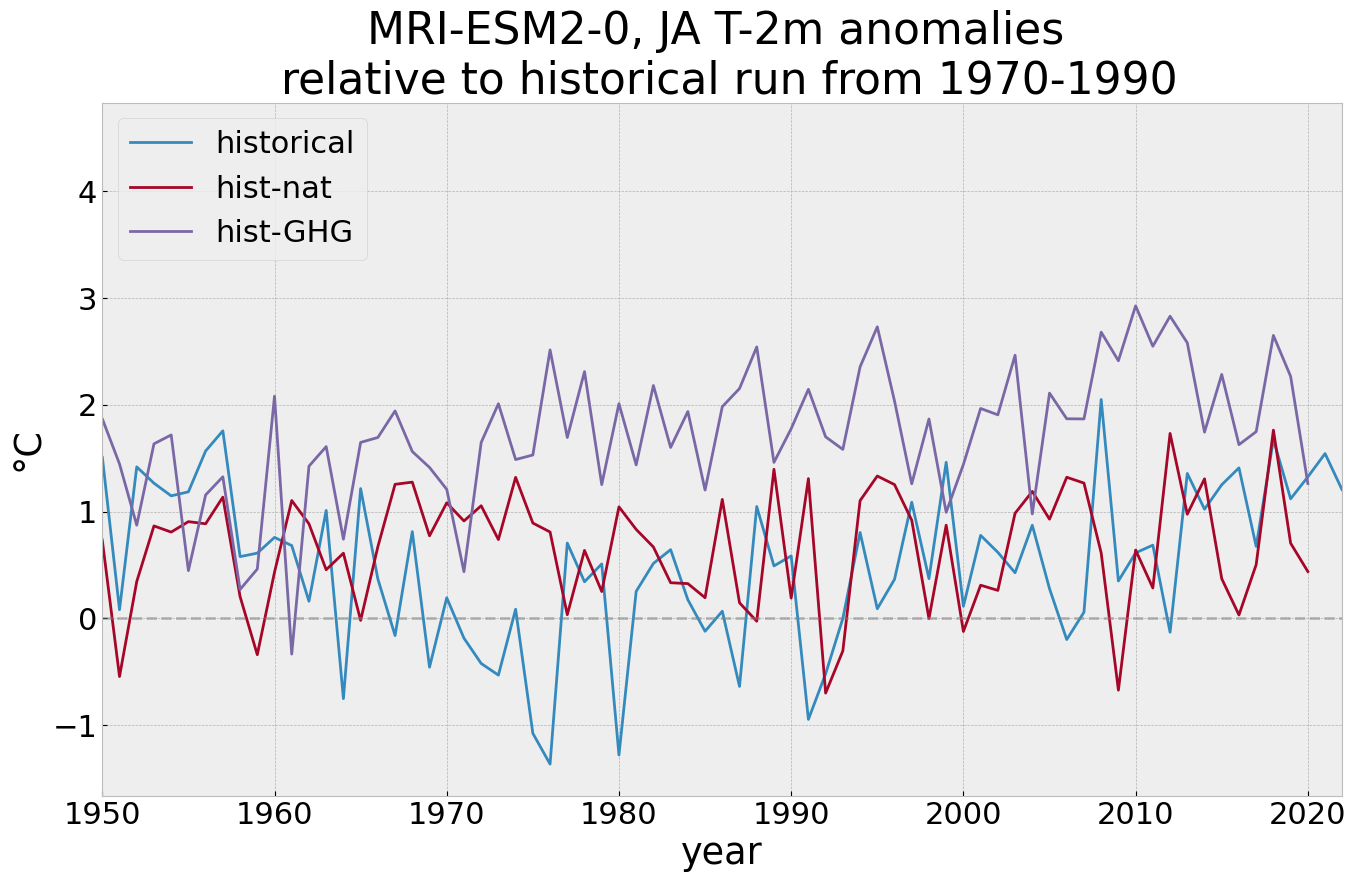

In [341]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['historical', 'hist-GHG', 'hist-nat']
# models_list = ['ACCESS-ESM1-5', 'CanESM5', 'IPSL-CM6A-LR', 'MRI-ESM2-0']

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

for model in models_list:
    temperature_anomalies = {}
    for exp in experiments_list:
        
        if exp == 'historical':
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/historical')
            file_name = glob('tasmax-extended_anomalies-hist-1970*.nc')[0]
            [
                variable, 
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tasmax']
        
        else:
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/' + exp)
            file_name = sorted(glob('tasmax_anomalies-hist-1970*.nc'))[0]
            [
                variable, 
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tasmax']

        

    [fig, ax] = plt.subplots(figsize=(16,9))
    ax.plot(
        temperature_anomalies[model + '_historical'].year, 
        temperature_anomalies[model + '_historical'],
        color='#348ABD',
        label='historical'
    )

    ax.plot(
        temperature_anomalies[model + '_hist-nat'].year, 
        temperature_anomalies[model + '_hist-nat'],
        color='#A60628',
        label='hist-nat'
    )

    ax.plot(
        temperature_anomalies[model + '_hist-GHG'].year, 
        temperature_anomalies[model + '_hist-GHG'],
        color='#7A68A6',
        label='hist-GHG'
    )
    ax.axhline(y=0, color='gray', alpha=0.5, ls='--')

    ax.legend(loc='upper left')
    ax.set_title(
        model + ', JA T-2m anomalies \n relative to historical run from ' 
        + reference_period.split('-')[2] + '-' + reference_period.split('-')[3])
    ax.set_ylabel('°C')
    ax.set_xlabel('year')
    ax.set_xlim(1950, 2022)
    ax.set_aspect('auto')

    plt.show()

    #     os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/')
    #     print(os.getcwd())
    #     picture_save_name = (
    #         'tasmax_anomalies-' 
    #         + str(reference_period.split('-')[1]) + '-' + str(reference_period.split('-')[2])
    #         + '_' + frequency 
    #         + '_' + model 
    #         + '.png'
    #     )

    #     plt.tight_layout(w_pad=5)
    #     plt.savefig(picture_save_name, dpi=400, format='png', bbox_inches='tight')
    #     plt.close()

# Sea Surface Temperature

## Calculate SST anomalies

In [39]:
(
    models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']

# exp = 'historical'
variable = 'tos'

for model in models_list:
    ################### historical ###################
    # Load the historical data
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model)

    # Load the data
    file_name_historical = sorted(glob('./historical/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_historical, 
        frequency_historical, 
        model_name_historical, 
        experiment_historical, 
        variant_historical, 
        grid_historical, 
        period_historical
    ] = file_name_historical.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_historical = xr.open_dataset(file_name_historical)[variable]
    
    
    ################### ssp245 ###################
    # Load the ssp245 data
    file_name_ssp = sorted(glob('./ssp245/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_ssp, 
        frequency_ssp, 
        model_name_ssp, 
        experiment_ssp, 
        variant_ssp, 
        grid_ssp, 
        period_ssp
    ] = file_name_ssp.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_ssp = xr.open_dataset(file_name_ssp)[variable]
    
    # Concatenate together the historical data and the ssp data
    # temperature_data_historical = xr.concat((temperature_data_historical, temperature_data_ssp), dim='time')
    period_extended = period_historical.split('-')[0] + '-' + period_ssp.split('-')[-1]
    
    # hist-GHG
    file_name_hist_GHG = sorted(glob('./hist-GHG/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_hist_GHG, 
        frequency_hist_GHG, 
        model_name_hist_GHG, 
        experiment_hist_GHG, 
        variant_hist_GHG, 
        grid_hist_GHG, 
        period_hist_GHG
    ] = file_name_hist_GHG.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_hist_GHG = xr.open_dataset(file_name_hist_GHG)[variable]
    
    # hist-nat
    file_name_hist_nat = sorted(glob('./hist-nat/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_hist_nat, 
        frequency_hist_nat, 
        model_name_hist_nat, 
        experiment_hist_nat, 
        variant_hist_nat, 
        grid_hist_nat, 
        period_hist_nat
    ] = file_name_hist_nat.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_hist_nat = xr.open_dataset(file_name_hist_nat)[variable]

    temperature_korea_historical = temperature_data_historical.sel(korea_sst_region).mean(dim=['lat','lon'])
    temperature_korea_ssp = temperature_data_ssp.sel(korea_sst_region).mean(dim=['lat','lon'])
    temperature_korea_hist_GHG = temperature_data_hist_GHG.sel(korea_sst_region).mean(dim=['lat','lon'])
    temperature_korea_hist_nat = temperature_data_hist_nat.sel(korea_sst_region).mean(dim=['lat','lon'])
        
    #### Compute anomalies ####
    # historical
    sea_surface_temperature_by_year_historical = temperature_korea_historical.sel(
        time=temperature_korea_historical['time.month'].isin([7,8])
    ).groupby('time.year').mean()
    
    #ssp245
    sea_surface_temperature_by_year_ssp = temperature_korea_ssp.sel(
        time=temperature_korea_ssp['time.month'].isin([7,8])
    ).groupby('time.year').mean()
    
    # hist-GHG 
    sea_surface_temperature_by_year_hist_GHG = temperature_korea_hist_GHG.sel(
        time=temperature_korea_hist_GHG['time.month'].isin([7,8])
    ).groupby('time.year').mean()

    # hist-nat
    sea_surface_temperature_by_year_hist_nat = temperature_korea_hist_nat.sel(
        time=temperature_korea_hist_nat['time.month'].isin([7,8])
    ).groupby('time.year').mean()

    # Compute the mean temperature of the reference period
    reference_period_mean_sea_surface_temperature_historical = sea_surface_temperature_by_year_historical.sel(reference_period).mean()

    # Compute anomalies from reference period
    summer_sea_surface_temperature_anomalies_historical = (
        sea_surface_temperature_by_year_historical 
        - reference_period_mean_sea_surface_temperature_historical
    )
    summer_sea_surface_temperature_anomalies_ssp = (
        sea_surface_temperature_by_year_ssp 
        - reference_period_mean_sea_surface_temperature_historical
    )
    summer_sea_surface_temperature_anomalies_extended = xr.concat(
        (
            summer_sea_surface_temperature_anomalies_historical, 
            summer_sea_surface_temperature_anomalies_ssp
        ), dim='year'
    )
    
    summer_sea_surface_temperature_anomalies_hist_GHG = (
        sea_surface_temperature_by_year_hist_GHG 
        - reference_period_mean_sea_surface_temperature_historical
    )
    summer_sea_surface_temperature_anomalies_hist_nat = (
        sea_surface_temperature_by_year_hist_nat 
        - reference_period_mean_sea_surface_temperature_historical
    )

    # Save
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model +'/')
    # os.system('chmod 700 ' + os.getcwd())
    # Create new file to save temperature anomalies
    new_file_name_historical = (
        variable_historical
        + '-regridded_extended_anomalies-hist-' + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
        + '_' + frequency_historical 
        + '_' + model
        + '_' + experiment_historical
        + '_' + variant_historical 
        + '_' + grid_historical
        + '_' + period_extended
        + '.nc'
    )

    # Save output to netCDF
    print(new_file_name_historical)
    summer_sea_surface_temperature_anomalies_extended.to_netcdf('./historical/' + new_file_name_historical)

    # Create new file to save temperature anomalies
    new_file_name_hist_GHG = (
        variable_hist_GHG
        + '-regridded_anomalies-hist-' + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
        + '_' + frequency_hist_GHG 
        + '_' + model
        + '_' + experiment_hist_GHG
        + '_' + variant_hist_GHG 
        + '_' + grid_hist_GHG
        + '_' + period_hist_GHG
        + '.nc'
    )

    # Save output to netCDF
    print(new_file_name_hist_GHG)
    summer_sea_surface_temperature_anomalies_hist_GHG.to_netcdf('./hist-GHG/' + new_file_name_hist_GHG)

    # Create new file to save temperature anomalies
    new_file_name_hist_nat = (
        variable_hist_nat
        + '-regridded_anomalies-hist-' + str(reference_period['year'].start) + '-' + str(reference_period['year'].stop)
        + '_' + frequency_hist_nat 
        + '_' + model
        + '_' + experiment_hist_nat
        + '_' + variant_hist_nat 
        + '_' + grid_hist_nat
        + '_' + period_hist_nat
        + '.nc'
    )

    # Save output to netCDF
    print(new_file_name_hist_nat)
    summer_sea_surface_temperature_anomalies_hist_nat.to_netcdf('./hist-nat/' + new_file_name_hist_nat)
        
print('finished')

tos-regridded_extended_anomalies-hist-1970-1990_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-210012.nc
tos-regridded_anomalies-hist-1970-1990_Omon_ACCESS-ESM1-5_hist-GHG_r1i1p1f1_gn_185001-202012.nc
tos-regridded_anomalies-hist-1970-1990_Omon_ACCESS-ESM1-5_hist-nat_r1i1p1f1_gn_185001-202012.nc
tos-regridded_extended_anomalies-hist-1970-1990_Omon_CanESM5_historical_r1i1p1f1_gn_185001-210012.nc
tos-regridded_anomalies-hist-1970-1990_Omon_CanESM5_hist-GHG_r1i1p1f1_gn_185001-202012.nc
tos-regridded_anomalies-hist-1970-1990_Omon_CanESM5_hist-nat_r1i1p1f1_gn_185001-202012.nc
tos-regridded_extended_anomalies-hist-1970-1990_Omon_CNRM-CM6-1_historical_r1i1p1f2_gr1_185001-210012.nc
tos-regridded_anomalies-hist-1970-1990_Omon_CNRM-CM6-1_hist-GHG_r1i1p1f2_gr1_185001-202012.nc
tos-regridded_anomalies-hist-1970-1990_Omon_CNRM-CM6-1_hist-nat_r1i1p1f2_gr1_185001-202012.nc
tos-regridded_extended_anomalies-hist-1970-1990_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_185001-210012.nc
tos-regridded_anom

## Calculate Twenty Year Mean

In [146]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['historical', 'hist-GHG', 'hist-nat']

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

twenty_year_mean_sea_surface_temperatures_hist_nat = {}
twenty_year_mean_sea_surface_temperatures_GHG_nat = {}
twenty_year_mean_sea_surface_temperatures_hist_GHG = {}

temperature_anomalies = {}
for model in models_list:
    for exp in experiments_list:
        if exp == 'historical':
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/historical/')
            file_name = sorted(glob('tos-regridded_extended_anomalies-hist*.nc'))[0]
            [
                variable, 
                extended,
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tos']
            
        else:
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/' + exp)
            file_name = sorted(glob('tos-regridded_anomalies-hist*.nc'))[0]
            [
                variable, 
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tos']
        
    twenty_year_mean_sea_surface_temperatures_hist_nat[model] = (
        temperature_anomalies[model + '_historical'].sel(year=slice(2000, 2020)).mean().values
      - temperature_anomalies[model + '_hist-nat'].sel(year=slice(2000, 2020)).mean().values
    )
    
    twenty_year_mean_sea_surface_temperatures_GHG_nat[model] = (
        temperature_anomalies[model + '_hist-GHG'].sel(year=slice(2000, 2020)).mean().values
      - temperature_anomalies[model + '_hist-nat'].sel(year=slice(2000, 2020)).mean().values
    )
    
    twenty_year_mean_sea_surface_temperatures_hist_GHG[model] = (
        temperature_anomalies[model + '_historical'].sel(year=slice(2000, 2020)).mean().values
      - temperature_anomalies[model + '_hist-GHG'].sel(year=slice(2000, 2020)).mean().values
    )

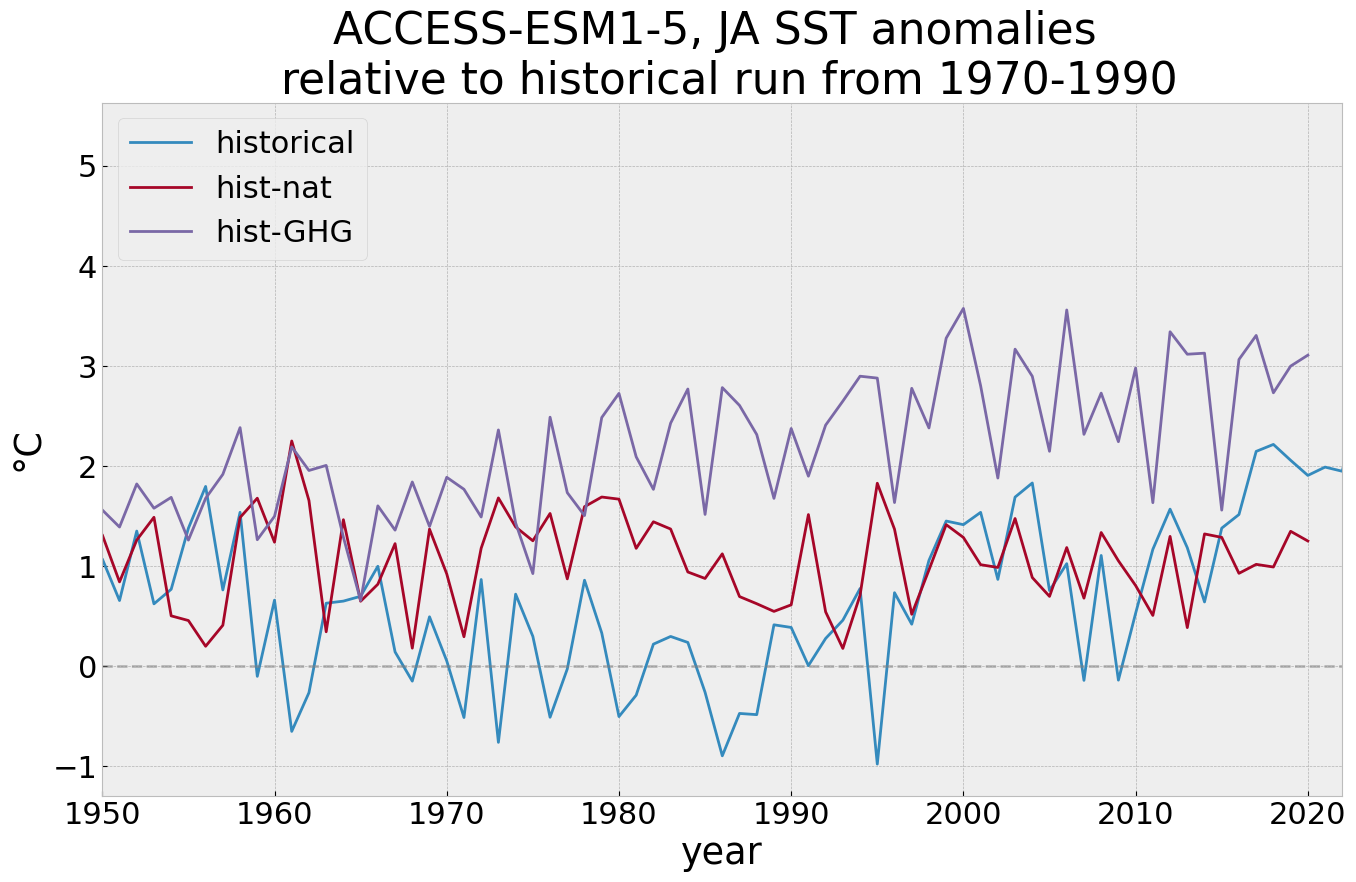

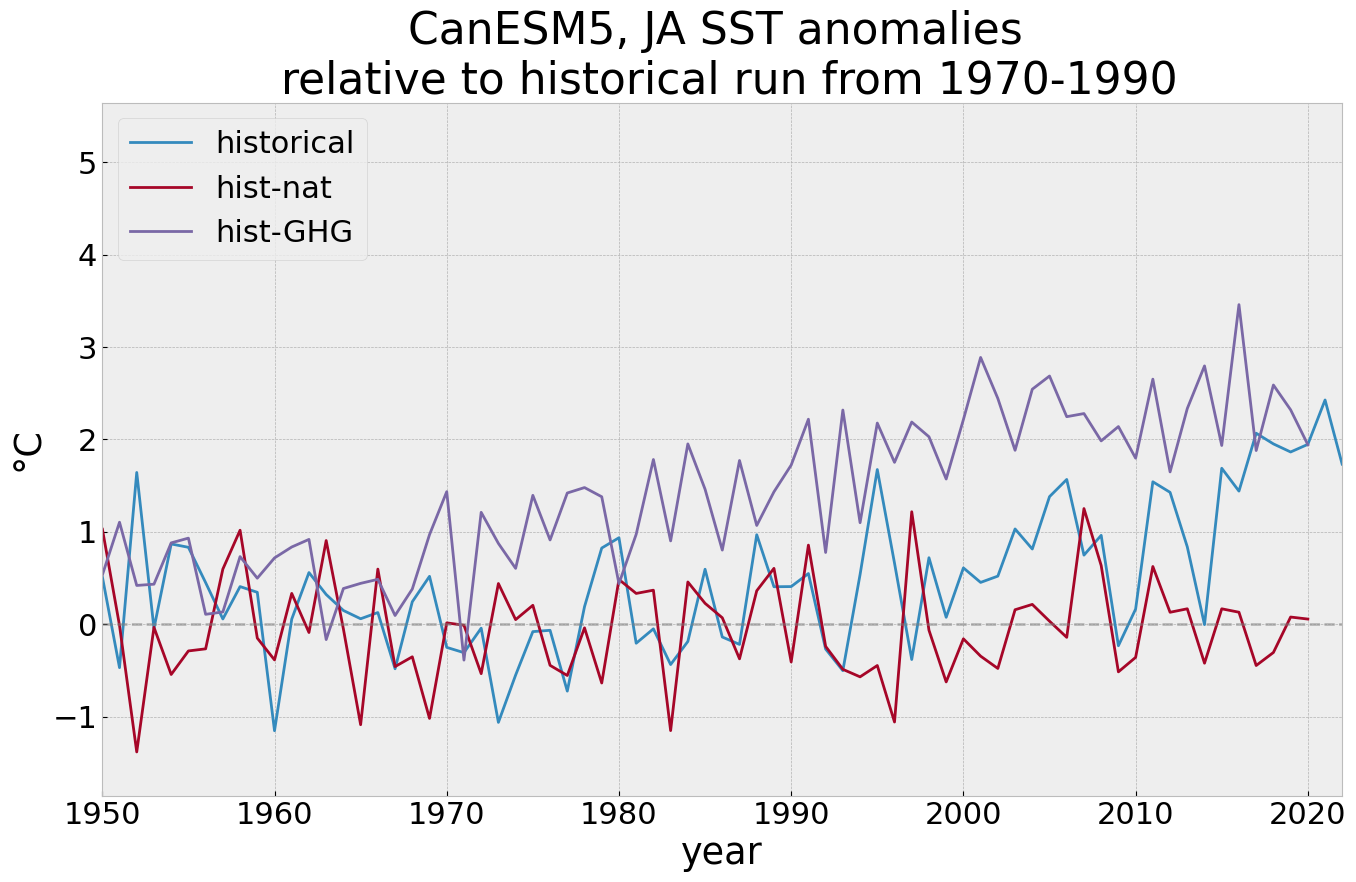

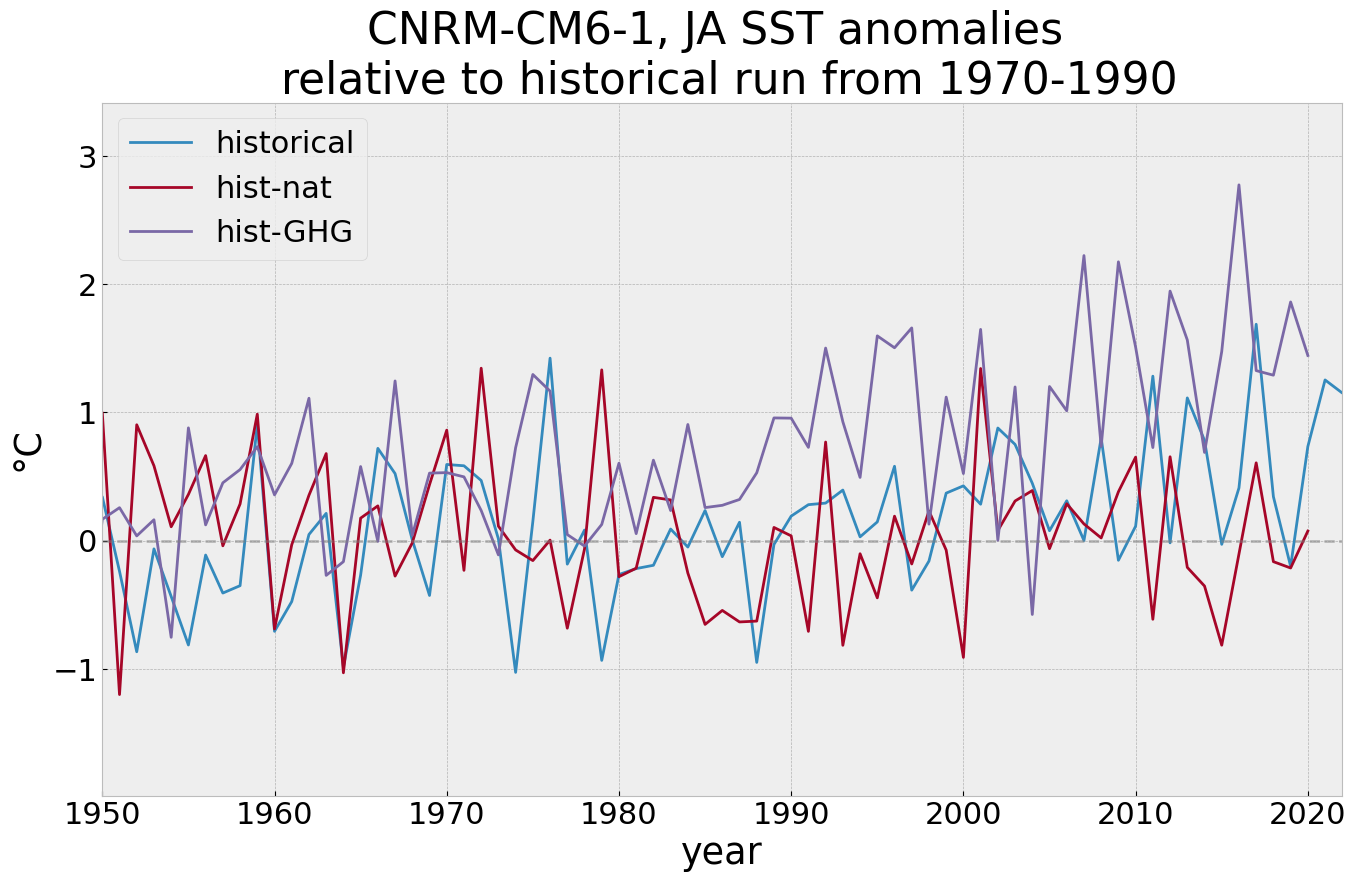

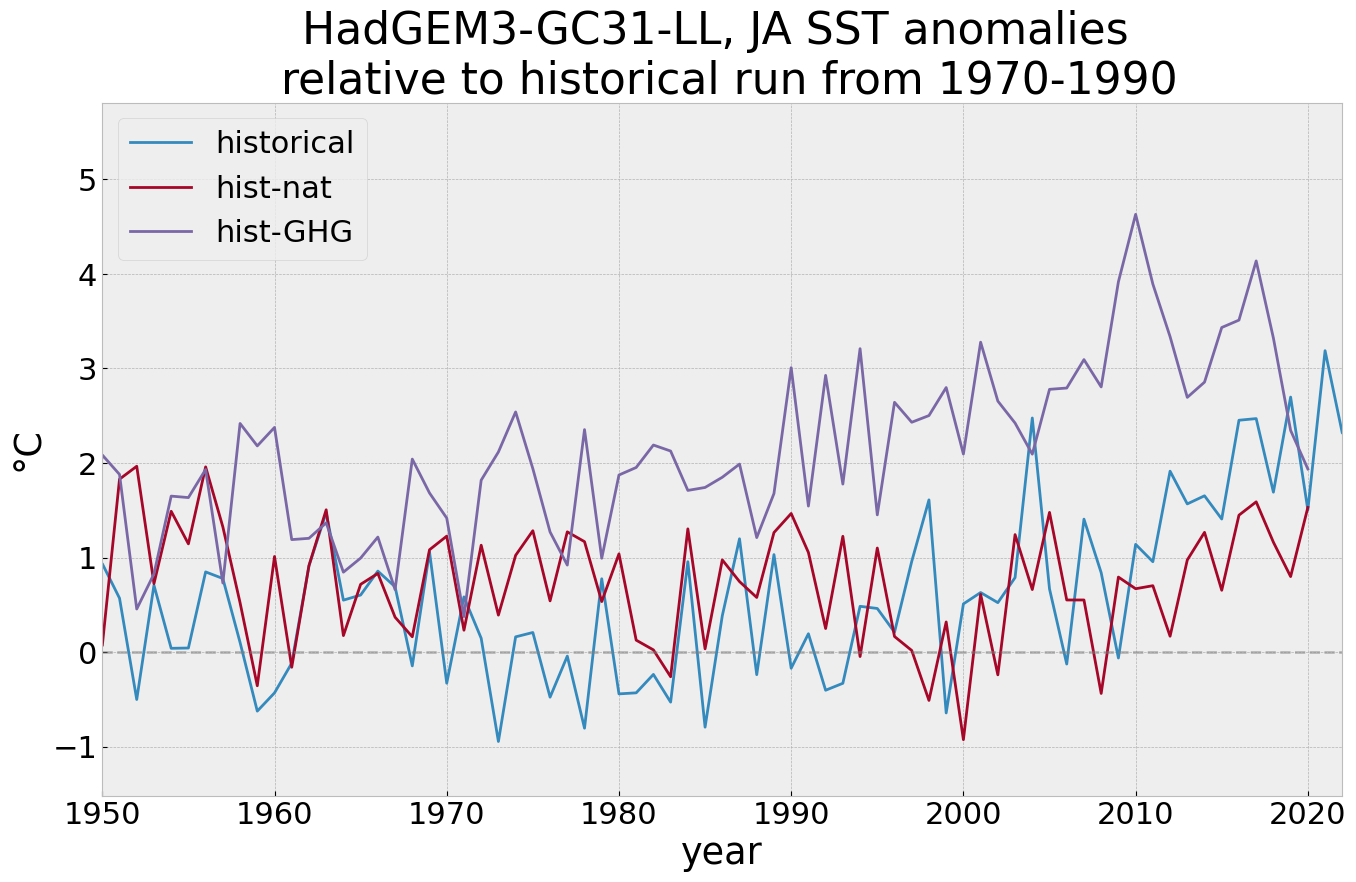

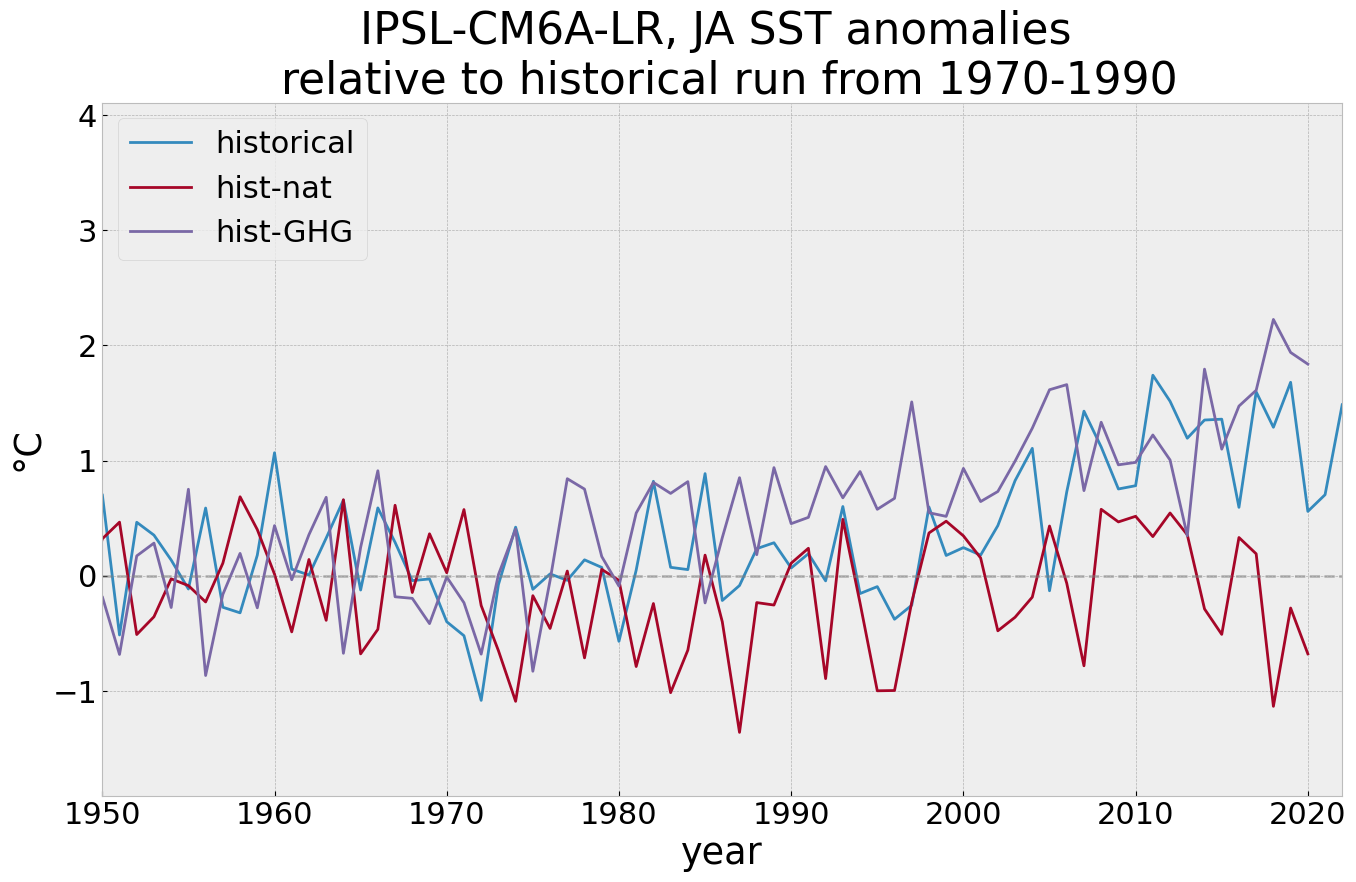

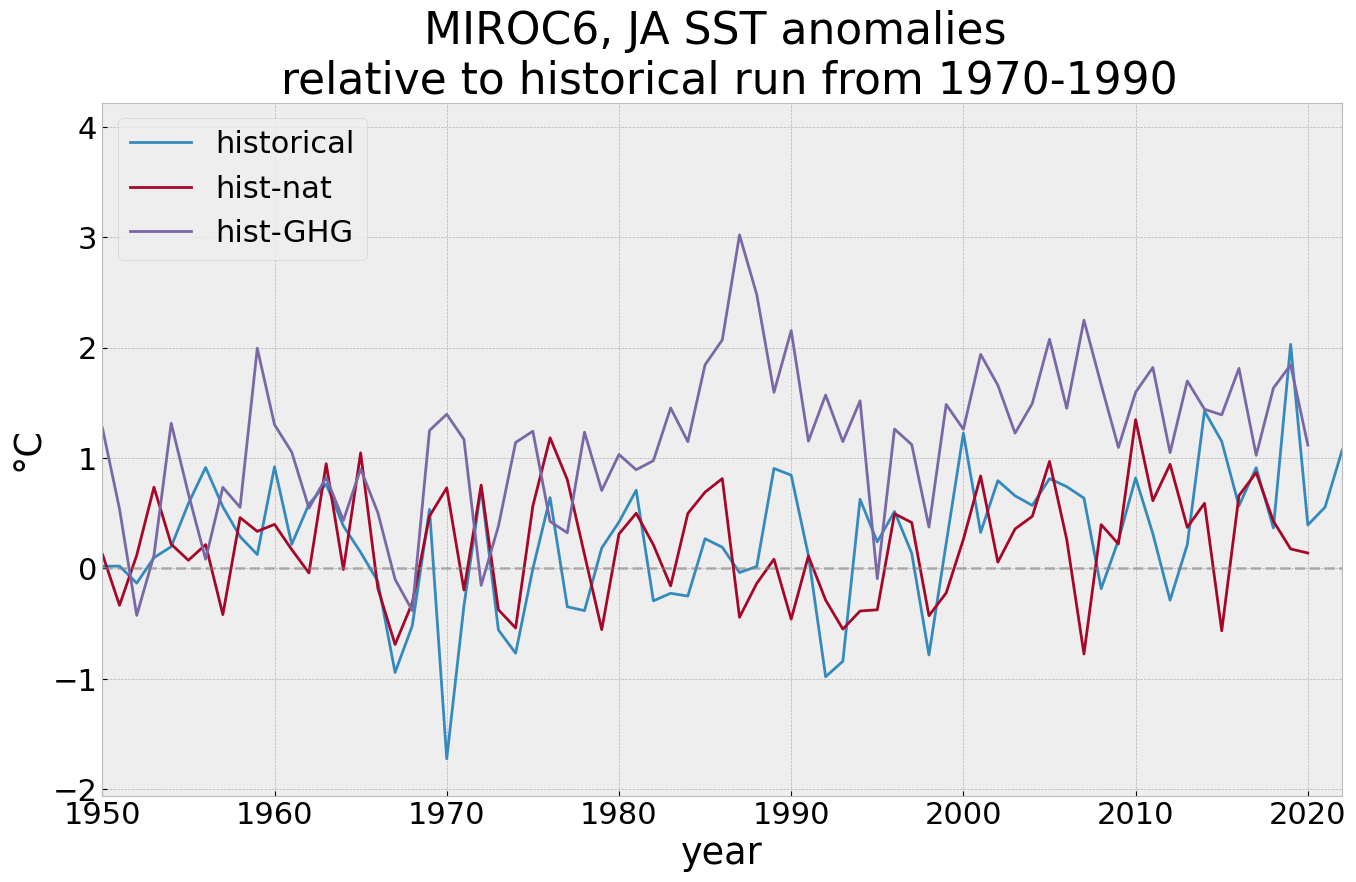

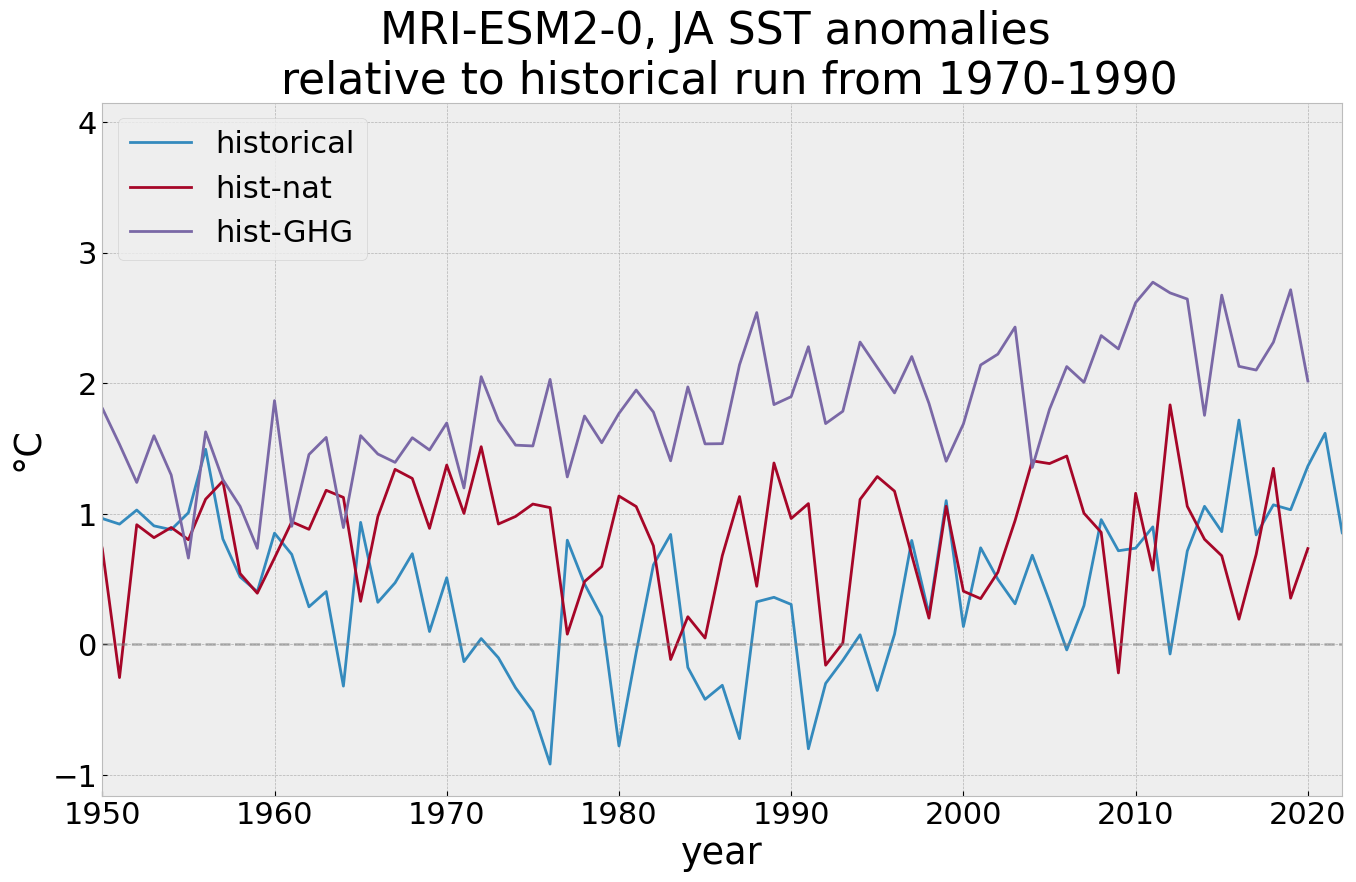

In [343]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['historical', 'hist-GHG', 'hist-nat']

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

twenty_year_mean_sea_surface_temperatures_GHG = {}
twenty_year_mean_sea_surface_temperatures_nat = {}
temperature_anomalies = {}
for model in models_list:
    for exp in experiments_list:
        if exp == 'historical':
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/historical/')
            file_name = sorted(glob('tos-regridded_extended_anomalies-hist*.nc'))[0]
            [
                variable, 
                extended,
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tos']
            
        else:
            # Set the directory
            os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/' + exp)
            file_name = sorted(glob('tos-regridded_anomalies-hist*.nc'))[0]
            [
                variable, 
                reference_period,
                frequency, 
                model_name, 
                experiment, 
                variant, 
                grid, 
                period
            ] = file_name.split('.nc')[0].split('_')
            temperature_anomalies[model + '_' + exp] = xr.open_dataset(file_name)['tos']

for model in models_list:
    [fig, ax] = plt.subplots(figsize=(16,9))
    ax.plot(
        temperature_anomalies[model + '_historical'].year, 
        temperature_anomalies[model + '_historical'],
        color='#348ABD',
        label='historical'
    )
    
    ax.plot(
        temperature_anomalies[model + '_hist-nat'].year, 
        temperature_anomalies[model + '_hist-nat'],
        color='#A60628',
        label='hist-nat'
    )
    
    ax.plot(
        temperature_anomalies[model + '_hist-GHG'].year, 
        temperature_anomalies[model + '_hist-GHG'],
        color='#7A68A6',
        label='hist-GHG'
    )
    ax.axhline(y=0, color='gray', alpha=0.5, ls='--')
    
    ax.legend(loc='upper left')
    ax.set_title(
        model + ', JA SST anomalies \n relative to historical run from ' 
        + reference_period.split('-')[2] + '-' + reference_period.split('-')[3])
    ax.set_ylabel('°C')
    ax.set_xlabel('year')
    ax.set_xlim(1950, 2022)
    ax.set_aspect('auto')
     
    plt.show()
    
#     os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/')
#     print(os.getcwd())
#     picture_save_name = (
#         'tasmax_anomalies-' 
#         + str(reference_period.split('-')[1]) + '-' + str(reference_period.split('-')[2])
#         + '_' + frequency 
#         + '_' + model 
#         + '.png'
#     )
    
#     plt.tight_layout(w_pad=5)
#     plt.savefig(picture_save_name, dpi=400, format='png', bbox_inches='tight')
#     plt.close()

## Plot SST maps

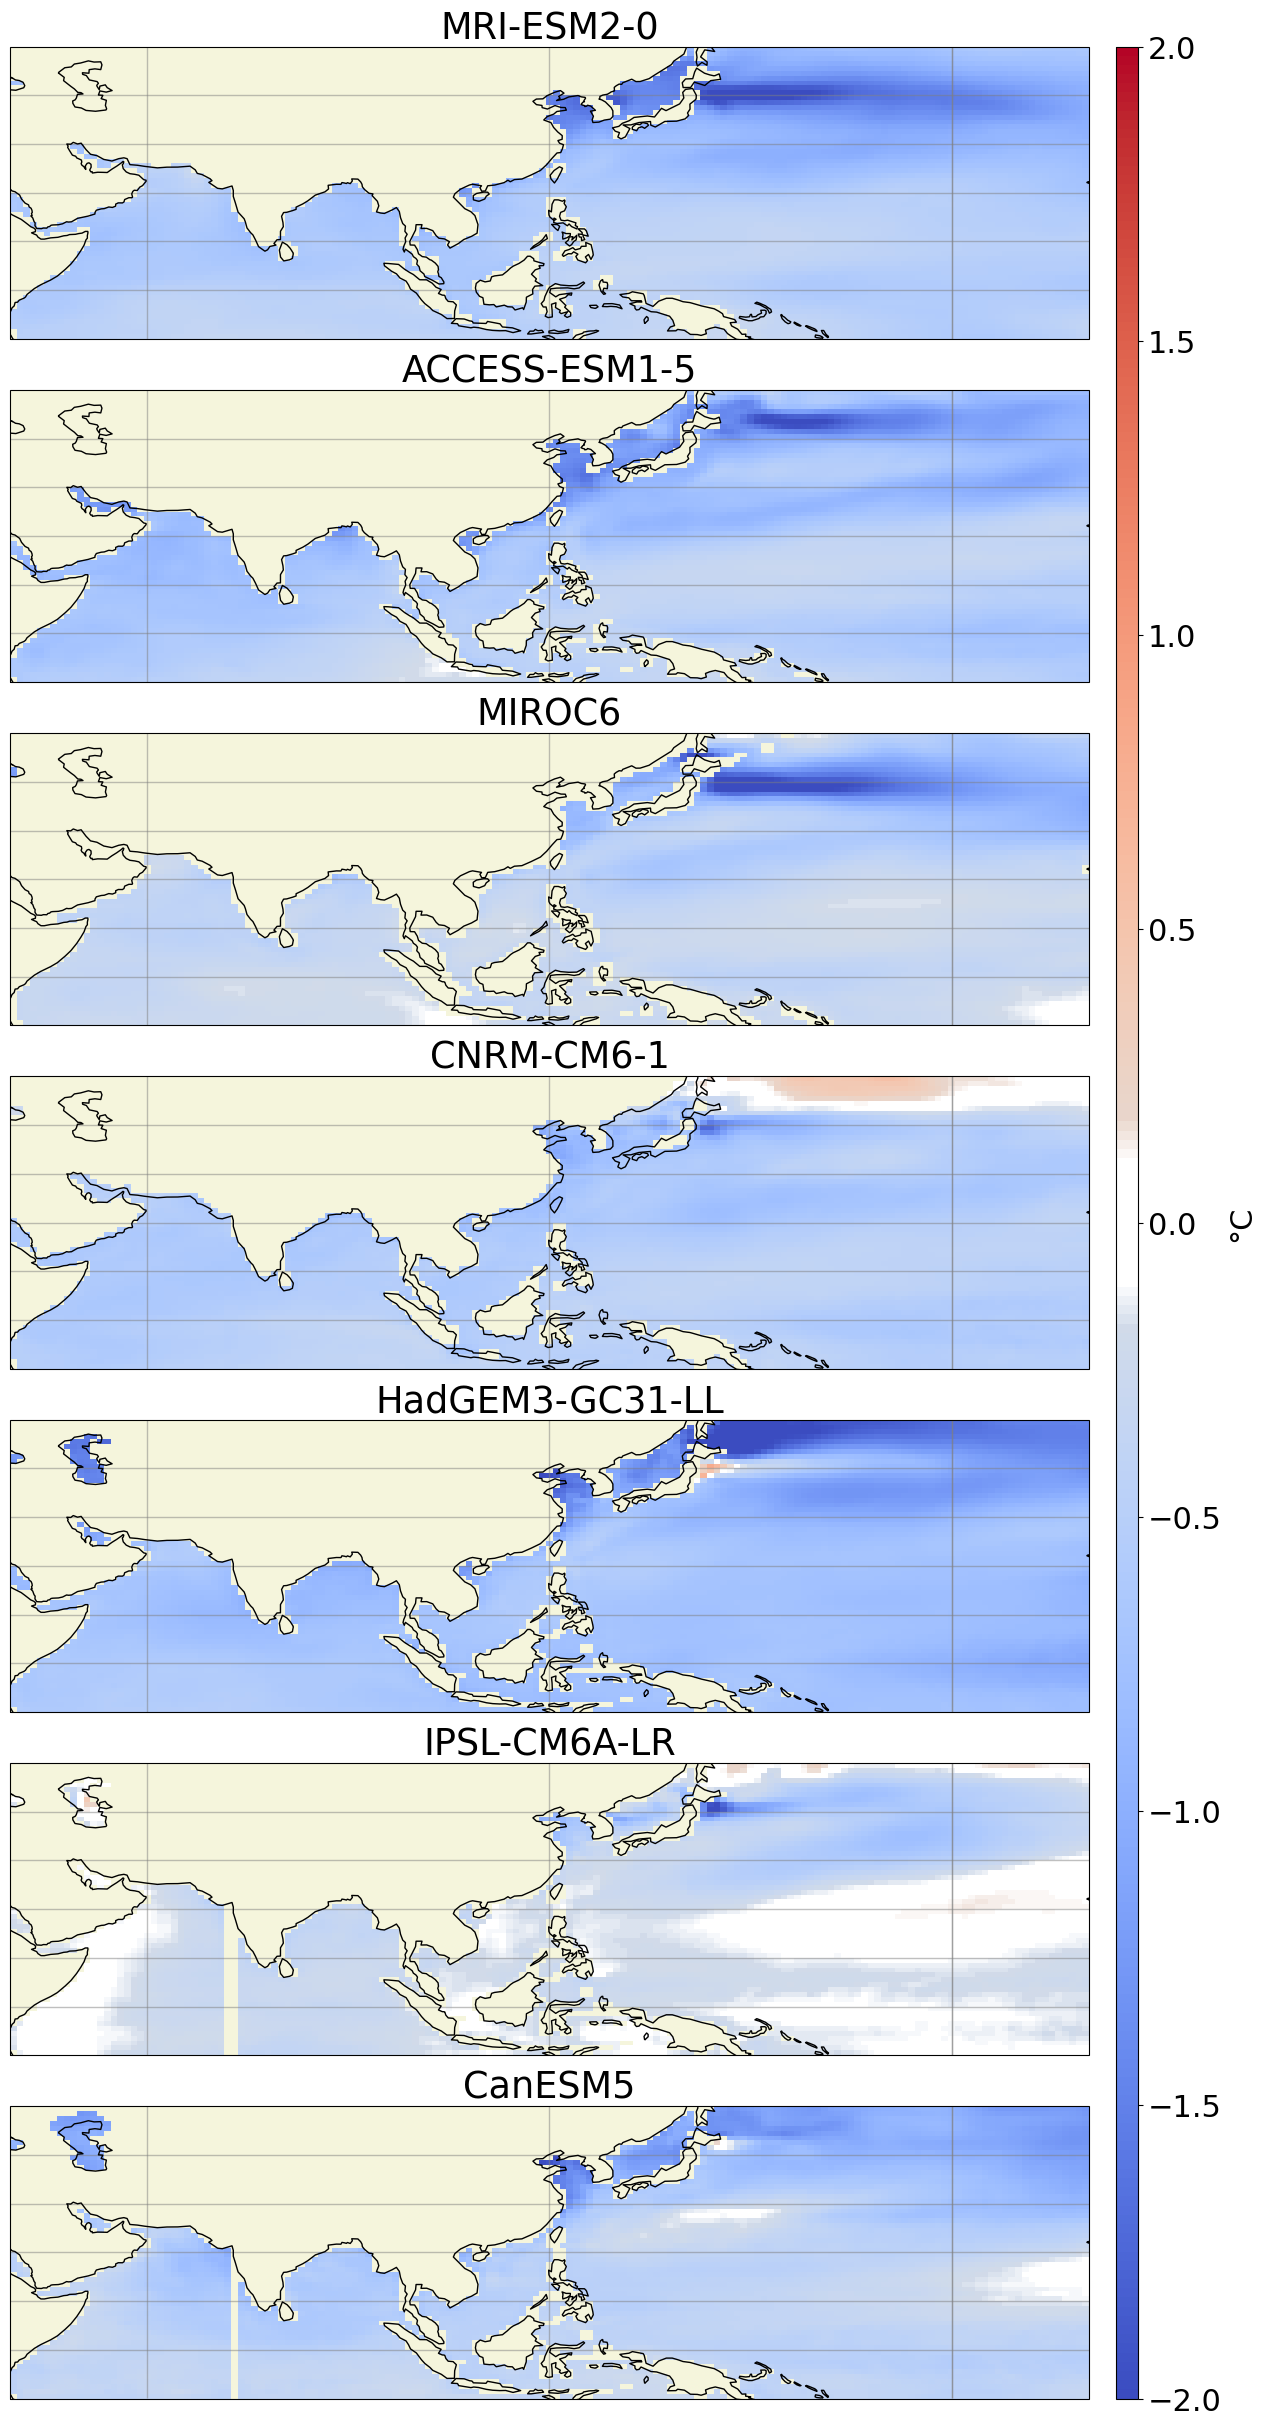

In [121]:
# models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']

models_list = ['MRI-ESM2-0', 'ACCESS-ESM1-5', 'MIROC6', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'CanESM5']
# models_list = ['ACCESS-ESM1-5', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
# experiment = ['historical']
variable = 'tos'

korea_south = -10
korea_north = 50
korea_west = 40
korea_east = 200

korea_sst_region = dict(lat=slice(-10,50), lon=slice(40,200))

plt.style.use('default')
plt.rcParams.update({'font.size':22})

fig = plt.figure(figsize=(12,24))
gs = GridSpec(7,2, width_ratios=[100,2], figure=fig)
gs.update(left=0.01, right=0.95, bottom=0.01, top=0.99, wspace=0.05, hspace=0.175)

ax = []
ax.append(fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[3,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[4,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[5,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[6,0], projection=ccrs.PlateCarree(central_longitude=120)))

cbar_ax = fig.add_subplot(gs[:,-1])

for index, model in enumerate(models_list):
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model)

    # Load the data
    file_name_historical = sorted(glob('./historical/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_historical, 
        frequency_historical, 
        model_name_historical, 
        experiment_historical, 
        variant_historical, 
        grid_historical, 
        period_historical
    ] = file_name_historical.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_historical = xr.open_dataset(file_name_historical)[variable]
    
    
    ################### ssp245 ###################
    # Load the ssp245 data
    file_name_ssp = sorted(glob('./ssp245/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_ssp, 
        frequency_ssp, 
        model_name_ssp, 
        experiment_ssp, 
        variant_ssp, 
        grid_ssp, 
        period_ssp
    ] = file_name_ssp.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_ssp = xr.open_dataset(file_name_ssp)[variable]
    
    # Concatenate together the historical data and the ssp data
    # temperature_data_historical = xr.concat((temperature_data_historical, temperature_data_ssp), dim='time')
    period_extended = period_historical.split('-')[0] + '-' + period_ssp.split('-')[-1]
    
    # hist-GHG
    file_name_hist_GHG = sorted(glob('./hist-GHG/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_hist_GHG, 
        frequency_hist_GHG, 
        model_name_hist_GHG, 
        experiment_hist_GHG, 
        variant_hist_GHG, 
        grid_hist_GHG, 
        period_hist_GHG
    ] = file_name_hist_GHG.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_hist_GHG = xr.open_dataset(file_name_hist_GHG)[variable]
    
    # hist-nat
    file_name_hist_nat = sorted(glob('./hist-nat/regridded_compiled_' + variable + '_*.nc'))[0]
    [
        regridded,
        variable_hist_nat, 
        frequency_hist_nat, 
        model_name_hist_nat, 
        experiment_hist_nat, 
        variant_hist_nat, 
        grid_hist_nat, 
        period_hist_nat
    ] = file_name_hist_nat.split('/')[-1].split('.nc')[0].split('_')[1:]

    temperature_data_hist_nat = xr.open_dataset(file_name_hist_nat)[variable]

    # Subset to Korean region
    temperature_korea_historical = temperature_data_historical.sel(korea_sst_region)
    temperature_korea_ssp = temperature_data_ssp.sel(korea_sst_region)
    temperature_korea_hist_GHG = temperature_data_hist_GHG.sel(korea_sst_region)
    temperature_korea_hist_nat = temperature_data_hist_nat.sel(korea_sst_region)
    
    # Concatenate historical and ssp2245 to get extended 
    temperature_korea_extended = xr.concat((temperature_korea_historical, temperature_korea_ssp), dim='time')
    
    # Calculate SST differences
    temperature_difference_hist_nat = temperature_korea_extended - temperature_korea_hist_nat
    twenty_year_mean_hist_nat = temperature_difference_hist_nat.sel(time=slice('2000','2020')).mean(dim='time')
    
    temperature_difference_GHG_nat = temperature_korea_hist_GHG - temperature_korea_hist_nat
    twenty_year_mean_GHG_nat = temperature_difference_GHG_nat.sel(time=slice('2000','2020')).mean(dim='time')
    
    temperature_difference_hist_GHG = temperature_korea_extended - temperature_korea_hist_GHG
    twenty_year_mean_hist_GHG = temperature_difference_hist_GHG.sel(time=slice('2000','2020')).mean(dim='time')
    
    # Plot SST differences
    cmap_modified = mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05)
    cmap_modified.set_bad(color='beige')
    ax[index].set_title(model)
    im = ax[index].pcolormesh(
        twenty_year_mean_hist_GHG.lon,
        twenty_year_mean_hist_GHG.lat,
        twenty_year_mean_hist_GHG,
        transform=ccrs.PlateCarree(),
        cmap=cmap_modified,
        norm=mcolors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2),
        # levels=np.arange(-0.5, 3, 0.1),
        # extend='both'
    )
    
    ax[index].set_aspect('auto')
    
    gl = ax[index].gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="-"
    )
    
    gl.right_labels=False
    gl.left_labels=False
    
    ax[index].add_feature(cfeature.COASTLINE, zorder=15)
    
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('°C')
plt.show()

# Heat Wave Statistics vs SST

## Calculate Twenty Year Mean

In [12]:
models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
experiments_list = ['ssp_extended', 'hist-GHG', 'hist-nat']

twenty_year_mean_HW_days_hist_nat = {}
twenty_year_mean_HW_days_GHG_nat = {}
twenty_year_mean_HW_days_hist_GHG = {}

twenty_year_mean_HW_frequency_hist_nat = {}
twenty_year_mean_HW_frequency_GHG_nat = {}
twenty_year_mean_HW_frequency_hist_GHG = {}

heat_wave_days = {}
heat_wave_frequency = {}

os.chdir('/home/disk/p/pangulo/CATER-Project/HeatWave_Statistics/Data')
for model in models_list:
    for experiment in experiments_list:
        file_name = glob(model + '_' + experiment + '_Korea_HW_days.nc')[0]
        # model_exp = file_name.split('.')[0].split('_')[:2]
        heat_wave_days[model + '_' + experiment] = xr.open_dataarray(file_name)
        
        if model == 'HadGEM3-GC31-LL':
            heat_wave_frequency[model + '_' + experiment] = heat_wave_days[model + '_' + experiment]/60
        
        else:
            heat_wave_frequency[model + '_' + experiment] = heat_wave_days[model + '_' + experiment]/62
   
    # Heat Wave Count
    twenty_year_mean_HW_days_hist_nat[model] = (
        heat_wave_days[model + '_ssp_extended'].sel(year=slice('2000', '2020')).mean()
      - heat_wave_days[model + '_hist-nat'].sel(year=slice('2000', '2020')).mean()
    )
    
    twenty_year_mean_HW_days_GHG_nat[model] = (
        heat_wave_days[model + '_hist-GHG'].sel(year=slice('2000', '2020')).mean()
      - heat_wave_days[model + '_hist-nat'].sel(year=slice('2000', '2020')).mean()
    )       
    
    twenty_year_mean_HW_days_hist_GHG[model] = (
        heat_wave_days[model + '_ssp_extended'].sel(year=slice('2000', '2020')).mean()
      - heat_wave_days[model + '_hist-GHG'].sel(year=slice('2000', '2020')).mean()
    )       
    
   
    # Heat Wave Frequency
#     twenty_year_mean_HW_frequency_hist_GHG[model] = (
#         heat_wave_frequency[model + '_hist-GHG'].sel(year=slice('2000', '2020')).mean()
#       - heat_wave_frequency[model + '_ssp_extended'].sel(year=slice('2000', '2020')).mean()
#     )
    
#     twenty_year_mean_HW_frequency_hist_nat[model] = (
#         heat_wave_frequency[model + '_ssp_extended'].sel(year=slice('2000', '2020')).mean()
#       - heat_wave_frequency[model + '_hist-nat'].sel(year=slice('2000', '2020')).mean()
#     )

## Plot SST vs T-2m

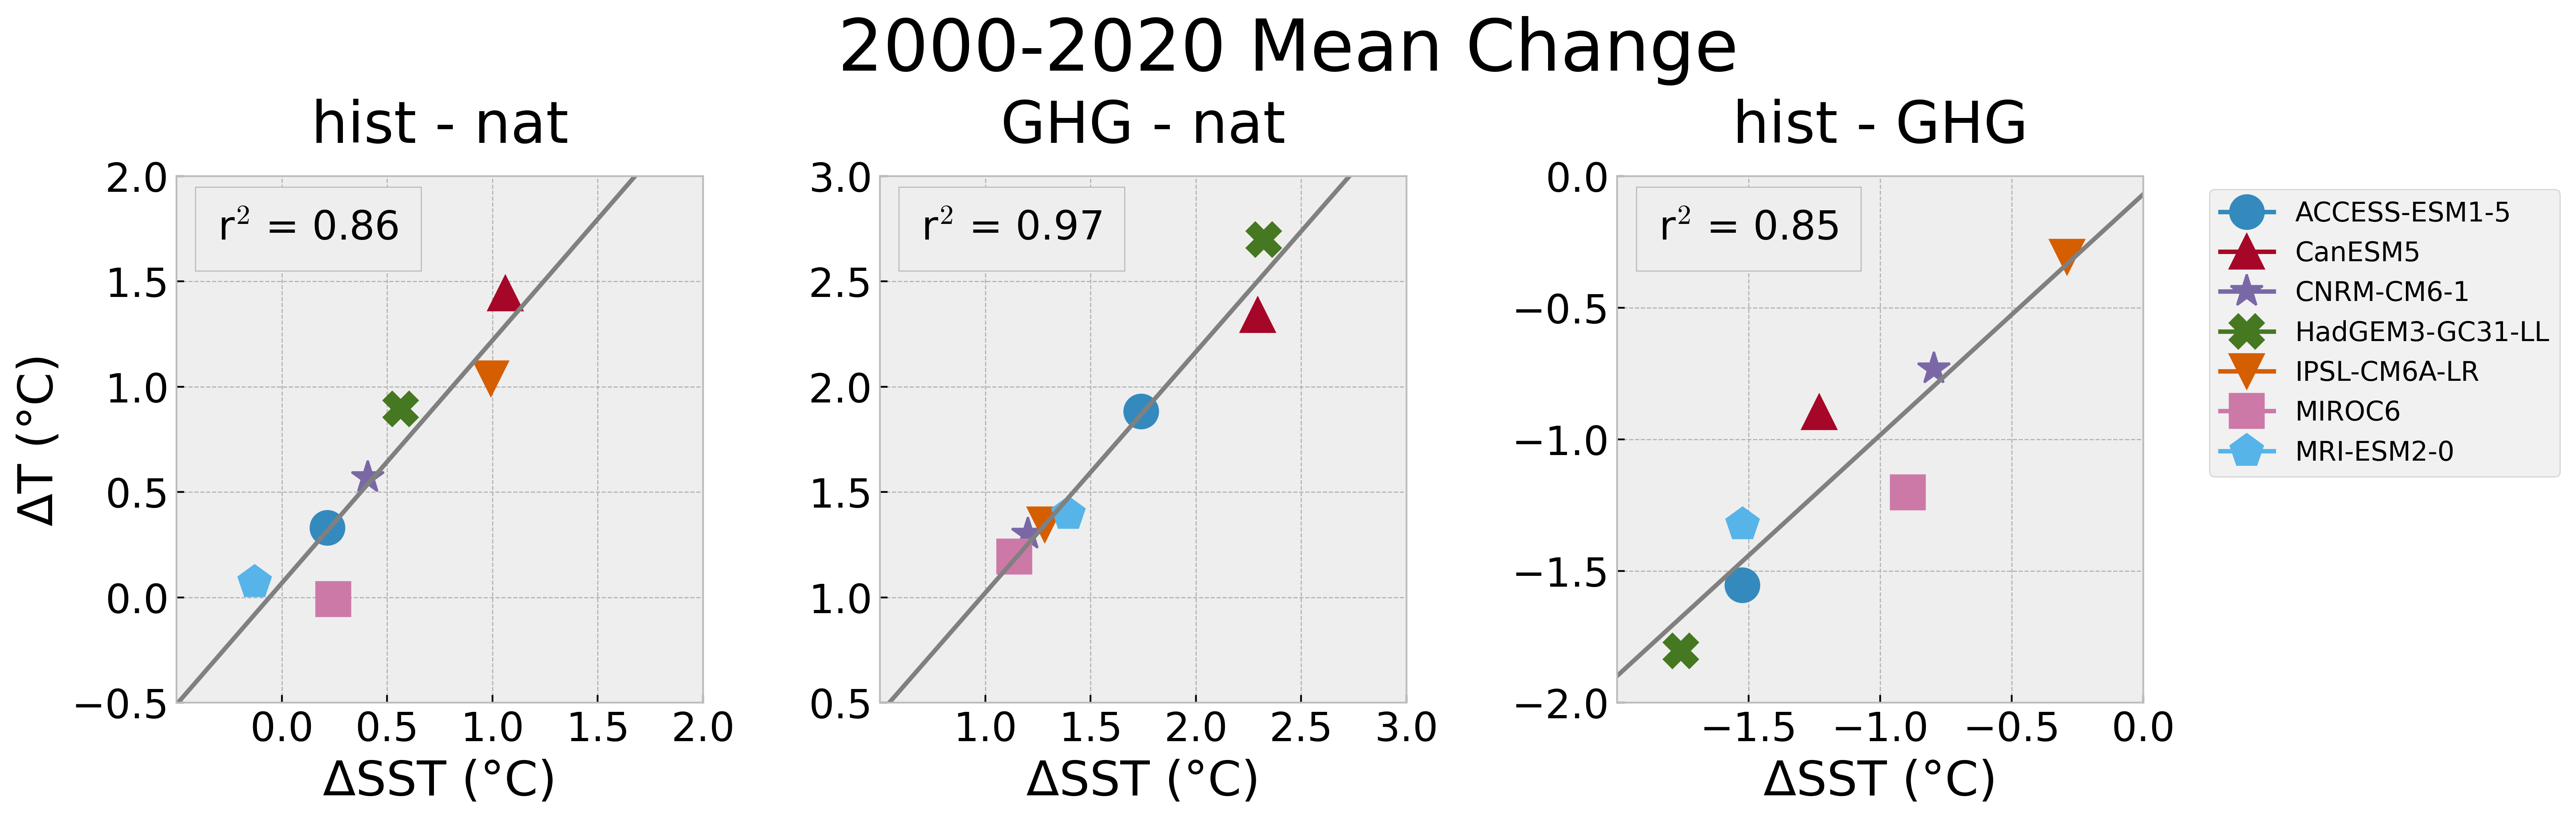

In [215]:
markers_list = {
    'ACCESS-ESM1-5':'o',
    'CanESM5':'^',
    'CNRM-CM6-1':'*',
    'HadGEM3-GC31-LL':'X',
    'IPSL-CM6A-LR':'v',
    'MIROC6':'s',
    'MRI-ESM2-0':'p'
}

plt.style.use('bmh')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16,5), constrained_layout=True, dpi=400)
gs = GridSpec(1, 3, width_ratios = [1,1,1], figure=fig)
gs.update(left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.075)
ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))
ax.append(fig.add_subplot(gs[2]))

############################ hist - nat ################################3

sst_points_hist_nat = np.empty((len(models_list)))
T_points_hist_nat = np.empty((len(models_list)))

for index, model in enumerate(twenty_year_mean_temperatures_hist_nat):
    sst_points_hist_nat[index] = twenty_year_mean_sea_surface_temperatures_hist_nat[model]
    T_points_hist_nat[index] = twenty_year_mean_temperatures_hist_nat[model]
    
    ax[0].plot(
        twenty_year_mean_sea_surface_temperatures_hist_nat[model], 
        twenty_year_mean_temperatures_hist_nat[model], 
        marker=markers_list[model], 
        markersize=15, 
        label=list(markers_list)[index]
    )

# Calculate and plot correlation coefficient
[slope, intercept] = np.polyfit(sst_points_hist_nat, T_points_hist_nat, 1)
correlation_coefficient = (slope*np.std(sst_points_hist_nat)/np.std(T_points_hist_nat))**2

ax[0].plot(np.linspace(-4,4,len(sst_points_hist_nat)), 
           np.polyval(
               [slope, intercept], 
               np.linspace(-4,4,len(sst_points_hist_nat))
           ), color='gray'
          )
ax[0].text(
    0.25, 0.9, 
    r"r$^{2}$ = " + f"{correlation_coefficient:0.2f}",
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax[0].transAxes,
    bbox={'facecolor':'#eeeeee', 'edgecolor':'#bcbcbc','pad':10}
)

min_val = -0.5
max_val = 2
ax[0].set_aspect('equal')

# ax[0].plot([min_val, max_val],[min_val, max_val], color='gray', alpha=0.5)
ax[0].set_xlim(min_val, max_val)
ax[0].set_xticks(np.arange(min_val, max_val+0.5, 0.5))
ax[0].set_ylim(min_val, max_val)
ax[0].set_yticks(np.arange(min_val, max_val+0.5, 0.5))
ax[0].yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax[0].xaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='lower'))

ax[0].set_title('hist - nat', pad=15)
ax[0].set_xlabel('ΔSST (°C)')
ax[0].set_ylabel('ΔT (°C)')
# ax[0].legend(loc='upper left', fontsize=12, ncol=2)


############################ GHG - nat ################################3

sst_points_GHG_nat = np.empty((len(models_list)))
T_points_GHG_nat = np.empty((len(models_list)))

for index, model in enumerate(twenty_year_mean_temperatures_GHG_nat):
    sst_points_GHG_nat[index] = twenty_year_mean_sea_surface_temperatures_GHG_nat[model]
    T_points_GHG_nat[index] = twenty_year_mean_temperatures_GHG_nat[model]
    
    ax[1].plot(
        twenty_year_mean_sea_surface_temperatures_GHG_nat[model], 
        twenty_year_mean_temperatures_GHG_nat[model], 
        marker=markers_list[model], 
        markersize=15, 
        label=list(markers_list)[index]
    )
    
# Calculate and plot correlation coefficient
[slope, intercept] = np.polyfit(sst_points_GHG_nat, T_points_GHG_nat, 1)
correlation_coefficient = (slope*np.std(sst_points_GHG_nat)/np.std(T_points_GHG_nat))**2

ax[1].plot(np.linspace(-4,4,len(sst_points_GHG_nat)), 
           np.polyval(
               [slope, intercept], 
               np.linspace(-4,4,len(sst_points_GHG_nat))
           ), color='gray'
          )
ax[1].text(
    0.25, 0.9, 
    r"r$^{2}$ = " + f"{correlation_coefficient:0.2f}",
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax[1].transAxes,
    bbox={'facecolor':'#eeeeee', 'edgecolor':'#bcbcbc','pad':10}
)

min_val = 0.5
max_val = 3
ax[1].set_aspect('equal')
# ax[1].plot([min_val, max_val],[min_val, max_val], color='gray', alpha=0.5)
ax[1].set_xlim(min_val, max_val)
ax[1].set_xticks(np.arange(min_val, max_val+0.5, 0.5))
ax[1].set_ylim(min_val, max_val)
ax[1].set_yticks(np.arange(min_val, max_val+0.5, 0.5))
ax[1].yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax[1].xaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='lower'))

ax[1].set_title('GHG - nat', pad=15)
ax[1].set_xlabel('ΔSST (°C)')
# ax[1].set_ylabel('ΔT (°C)')

############################ hist - GHG ################################3

sst_points_hist_GHG = np.empty((len(models_list)))
T_points_hist_GHG = np.empty((len(models_list)))

for index, model in enumerate(twenty_year_mean_temperatures_hist_GHG):
    sst_points_hist_GHG[index] = twenty_year_mean_sea_surface_temperatures_hist_GHG[model]
    T_points_hist_GHG[index] = twenty_year_mean_temperatures_hist_GHG[model]
    
    ax[2].plot(
        twenty_year_mean_sea_surface_temperatures_hist_GHG[model], 
        twenty_year_mean_temperatures_hist_GHG[model], 
        marker=markers_list[model], 
        markersize=15, 
        label=list(markers_list)[index]
    )
    
# Calculate and plot correlation coefficient
[slope, intercept] = np.polyfit(sst_points_hist_GHG, T_points_hist_GHG, 1)
correlation_coefficient = (slope*np.std(sst_points_hist_GHG)/np.std(T_points_hist_GHG))**2

ax[2].plot(np.linspace(-4,4,len(sst_points_hist_GHG)), 
           np.polyval(
               [slope, intercept], 
               np.linspace(-4,4,len(sst_points_hist_GHG))
           ), color='gray'
          )
ax[2].text(
    0.25, 0.9, 
    r"r$^{2}$ = " + f"{correlation_coefficient:0.2f}",
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax[2].transAxes,
    bbox={'facecolor':'#eeeeee', 'edgecolor':'#bcbcbc','pad':10}
)

min_val = -2
max_val = 0
ax[2].set_aspect('equal')
# ax[2].plot([min_val, max_val],[min_val, max_val], color='gray', alpha=0.5)
ax[2].set_xlim(min_val, max_val)
ax[2].set_xticks(np.arange(min_val, max_val+0.5, 0.5))
ax[2].set_ylim(min_val, max_val)
ax[2].set_yticks(np.arange(min_val, max_val+0.5, 0.5))
ax[2].yaxis.set_major_locator(mticker.MaxNLocator(nbins=4))
ax[2].xaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='lower'))

ax[2].set_title('hist - GHG', pad=15)
ax[2].set_xlabel('ΔSST (°C)')


ax[-1].legend(fontsize=12, ncol=1, bbox_to_anchor=(1.1,1))

fig.suptitle('2000-2020 Mean Change', fontsize=32)
plt.show()

# plt.savefig('/home/disk/p/sressel/CATER-Project/hist-GHG_minus_historical.jpg', dpi=400)

## Plot SST vs HW days

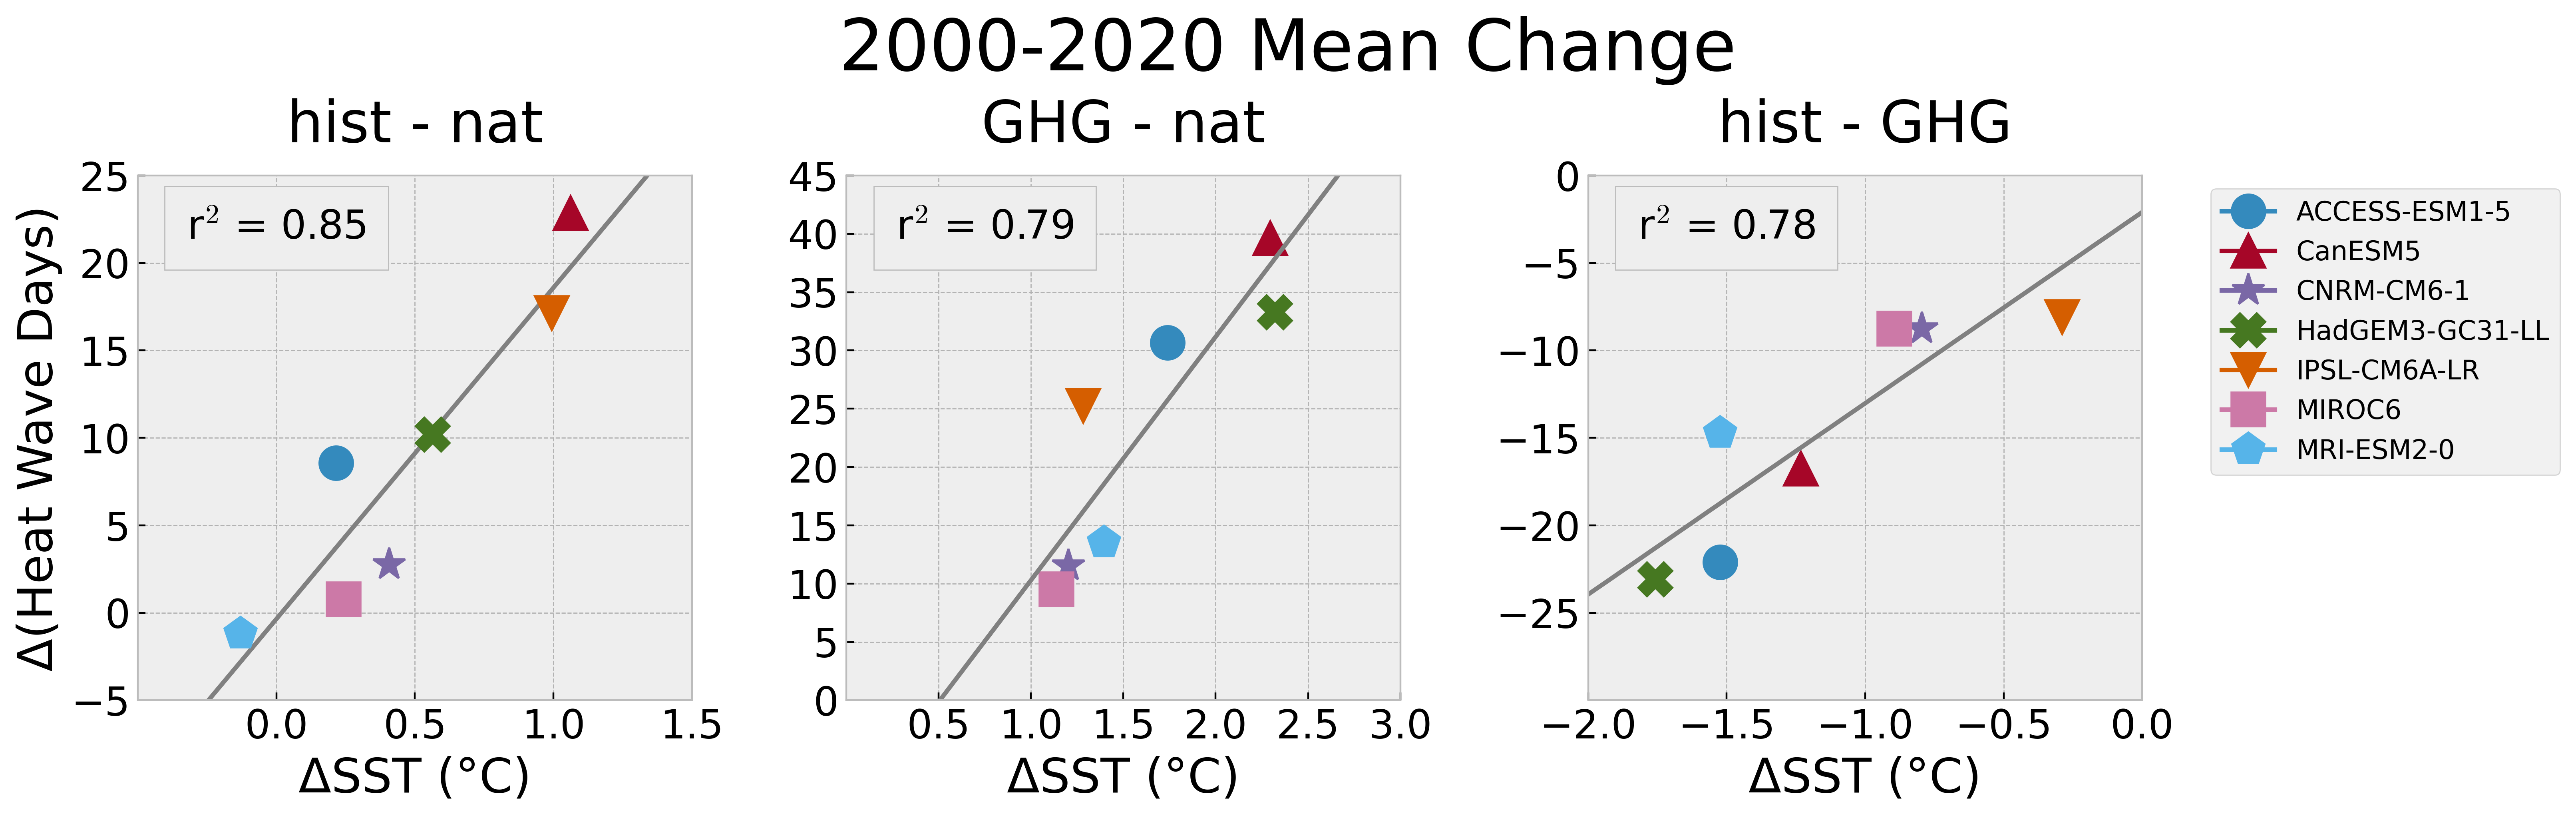

In [217]:
markers_list = {
    'ACCESS-ESM1-5':'o',
    'CanESM5':'^',
    'CNRM-CM6-1':'*',
    'HadGEM3-GC31-LL':'X',
    'IPSL-CM6A-LR':'v',
    'MIROC6':'s',
    'MRI-ESM2-0':'p'
}

plt.style.use('bmh')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16,5), constrained_layout=True, dpi=400)
gs = GridSpec(1, 3, width_ratios = [1,1,1], figure=fig)
gs.update(left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.075)
ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))
ax.append(fig.add_subplot(gs[2]))

sst_points_hist_nat = np.empty((len(models_list)))
hw_days_hist_nat = np.empty((len(models_list)))

for index, model in enumerate(twenty_year_mean_temperatures_hist_nat):
    sst_points_hist_nat[index] = twenty_year_mean_sea_surface_temperatures_hist_nat[model]
    hw_days_hist_nat[index] = twenty_year_mean_HW_days_hist_nat[model]
    
    ax[0].plot(
        twenty_year_mean_sea_surface_temperatures_hist_nat[model], 
        twenty_year_mean_HW_days_hist_nat[model], 
        marker=markers_list[model], 
        markersize=15, 
        label=list(markers_list)[index],
        zorder=101
    )
    
# Calculate and plot correlation coefficient
[slope, intercept] = np.polyfit(sst_points_hist_nat, hw_days_hist_nat, 1)
correlation_coefficient = (slope*np.std(sst_points_hist_nat)/np.std(hw_days_hist_nat))**2

ax[0].plot(np.linspace(-4,4,len(sst_points_hist_nat)), 
           np.polyval(
               [slope, intercept], 
               np.linspace(-4,4,len(sst_points_hist_nat))
           ), color='gray'
          )
ax[0].text(
    0.25, 0.9, 
    r"r$^{2}$ = " + f"{correlation_coefficient:0.2f}",
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax[0].transAxes,
    bbox={'facecolor':'#eeeeee', 'edgecolor':'#bcbcbc', 'pad':10}
)
    
# ax[0].axhline(y=0, color='gray', ls=':', lw=2, zorder=100)
# ax[0].axvline(x=0, color='gray', ls=':', lw=2, zorder=100)

min_val = -0.5
max_val = 1.5
ax[0].set_aspect('auto')
# ax[0].plot([min_val, max_val],[min_val, max_val], color='gray', alpha=0.5)
ax[0].set_xlim(min_val, max_val)
ax[0].set_xticks(np.arange(min_val, max_val+0.5, 0.5))
ax[0].set_ylim(-5, 25)
ax[0].set_yticks(np.arange(-5, 25+5, 5))
ax[0].yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
ax[0].xaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='lower'))

ax[0].set_title('hist - nat', pad=15)
ax[0].set_xlabel('ΔSST (°C)')
ax[0].set_ylabel('Δ(Heat Wave Days)')
# ax[0].legend(loc='upper left', fontsize=12, ncol=2)


#################### GHG - nat ############################
sst_points_GHG_nat = np.empty((len(models_list)))
hw_days_GHG_nat = np.empty((len(models_list)))

for index, model in enumerate(twenty_year_mean_temperatures_GHG_nat):
    sst_points_GHG_nat[index] = twenty_year_mean_sea_surface_temperatures_GHG_nat[model]
    hw_days_GHG_nat[index] = twenty_year_mean_HW_days_GHG_nat[model]
    
    ax[1].plot(
            twenty_year_mean_sea_surface_temperatures_GHG_nat[model], 
            twenty_year_mean_HW_days_GHG_nat[model], 
            marker=markers_list[model], 
            markersize=15, 
            label=list(markers_list)[index]
        )
    
# Calculate and plot correlation coefficient
[slope, intercept] = np.polyfit(sst_points_GHG_nat, hw_days_GHG_nat, 1)
correlation_coefficient = (slope*np.std(sst_points_GHG_nat)/np.std(hw_days_GHG_nat))**2

ax[1].plot(np.linspace(-4,4,len(sst_points_GHG_nat)), 
           np.polyval(
               [slope, intercept], 
               np.linspace(-4,4,len(sst_points_GHG_nat))
           ), color='gray'
          )
ax[1].text(
    0.25, 0.9, 
    r"r$^{2}$ = " + f"{correlation_coefficient:0.2f}",
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax[1].transAxes,
    bbox={'facecolor':'#eeeeee', 'edgecolor':'#bcbcbc', 'pad':10}
)
x_min_val = 0
x_max_val = 3
y_min_val = 0
y_max_val = 45


ax[1].set_aspect('auto')
# ax[1].plot([min_val, max_val],[min_val, max_val], color='gray', alpha=0.5)
ax[1].set_xlim(x_min_val, x_max_val)
ax[1].set_xticks(np.arange(x_min_val, x_max_val+0.5, 0.5))
ax[1].set_ylim(y_min_val, y_max_val)
ax[1].set_yticks(np.arange(y_min_val, y_max_val+5, 5))
ax[1].yaxis.set_major_locator(mticker.MaxNLocator(nbins=10))
ax[1].xaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune='lower'))

ax[1].set_title('GHG - nat', pad=15)
ax[1].set_xlabel('ΔSST (°C)')
# ax[1].set_ylabel('ΔT (°C)')

#################### hist - GHG ############################
sst_points_hist_GHG = np.empty((len(models_list)))
hw_days_hist_GHG = np.empty((len(models_list)))

for index, model in enumerate(twenty_year_mean_temperatures_hist_GHG):
    sst_points_hist_GHG[index] = twenty_year_mean_sea_surface_temperatures_hist_GHG[model]
    hw_days_hist_GHG[index] = twenty_year_mean_HW_days_hist_GHG[model]
    
    ax[2].plot(
        twenty_year_mean_sea_surface_temperatures_hist_GHG[model], 
        twenty_year_mean_HW_days_hist_GHG[model], 
        marker=markers_list[model], 
        markersize=15, 
        label=list(markers_list)[index]
    )

# Calculate and plot correlation coefficient
[slope, intercept] = np.polyfit(sst_points_hist_GHG, hw_days_hist_GHG, 1)
correlation_coefficient = (slope*np.std(sst_points_hist_GHG)/np.std(hw_days_hist_GHG))**2

ax[2].plot(np.linspace(-4,4,len(sst_points_hist_GHG)), 
           np.polyval(
               [slope, intercept], 
               np.linspace(-4,4,len(sst_points_hist_GHG))
           ), color='gray'
          )
ax[2].text(
    0.25, 0.9, 
    r"r$^{2}$ = " + f"{correlation_coefficient:0.2f}",
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax[2].transAxes,
    bbox={'facecolor':'#eeeeee', 'edgecolor':'#bcbcbc', 'pad':10}
)
    
x_min_val = -2
x_max_val = 0
y_min_val = -30
y_max_val = 0
ax[2].set_aspect('auto')
# ax[2].plot([min_val, max_val],[min_val, max_val], color='gray', alpha=0.5)
ax[2].set_xlim(x_min_val, x_max_val)
ax[2].set_xticks(np.arange(x_min_val, x_max_val+0.5, 0.5))
ax[2].set_ylim(y_min_val, y_max_val)
ax[2].set_yticks(np.arange(y_min_val, y_max_val+5, 5))
ax[2].yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune='lower'))
# ax[2].xaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='lower'))

ax[2].set_title('hist - GHG', pad=15)
ax[2].set_xlabel('ΔSST (°C)')


ax[-1].legend(fontsize=12, ncol=1, bbox_to_anchor=(1.1,1))

fig.suptitle('2000-2020 Mean Change', fontsize=32)
plt.show()

# plt.savefig('/home/disk/p/sressel/CATER-Project/hist-GHG_minus_historical.jpg', dpi=400)

## Plot SST vs HW Frequency 

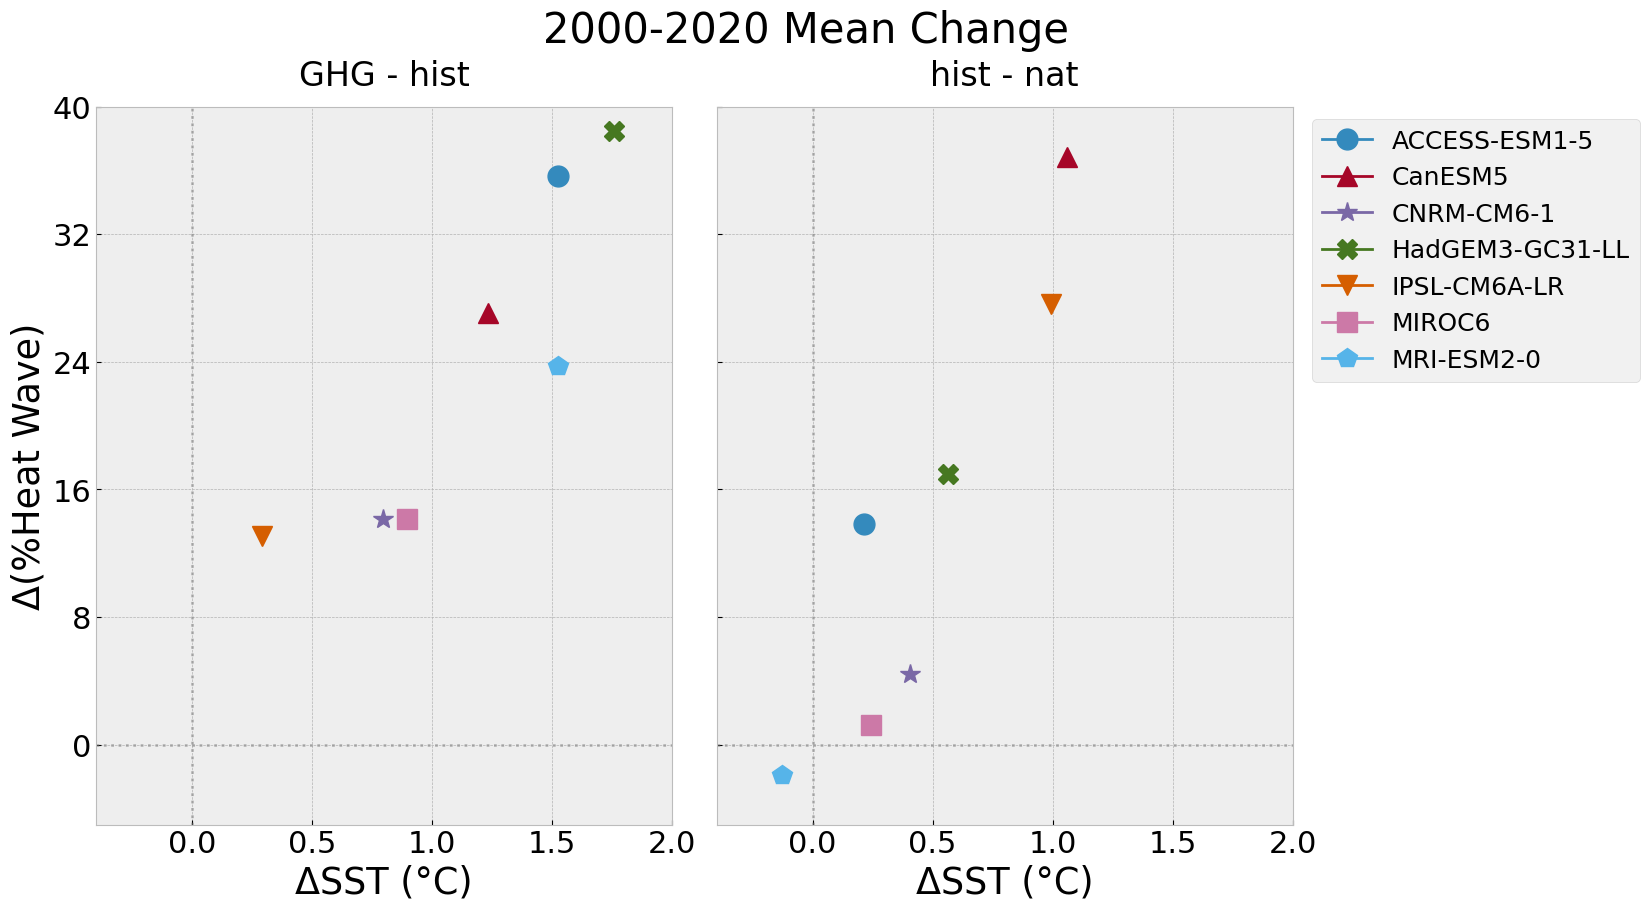

In [358]:
markers_list = {
    'ACCESS-ESM1-5':'o',
    'CanESM5':'^',
    'CNRM-CM6-1':'*',
    'HadGEM3-GC31-LL':'X',
    'IPSL-CM6A-LR':'v',
    'MIROC6':'s',
    'MRI-ESM2-0':'p'
}

# Specify plot limits
plot_xlims = [-0.4, 2]
plot_ylims = [-5, 40]
    
# Create figure and axes
fig = plt.figure(figsize=(16,9), constrained_layout=True)
gs = GridSpec(1, 2, width_ratios = [1,1], figure=fig)
gs.update(left = 0.05, right = 0.95, bottom = 0.05, top = 0.95, wspace = 0.025)
ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))
fig.suptitle('2000-2020 Mean Change', fontsize=30)

# Plot data
for index, model in enumerate(twenty_year_mean_temperatures_hist_GHG):
    ax[0].plot(
        twenty_year_mean_sea_surface_temperatures_GHG[model], 
        100*twenty_year_mean_HW_frequency_hist_GHG[model], 
        marker=markers_list[model], 
        markersize=15, 
        label=list(markers_list)[index]
    )
    
# Lines for the x- and y-axes
ax[0].axhline(y=0, color='gray', alpha=0.5, ls=':')
ax[0].axvline(x=0, color='gray', alpha=0.5, ls=':')


# Configure and label axes
ax[0].set_aspect('auto')

# x-axis
ax[0].set_xlim(plot_xlims[0], plot_xlims[1])
# ax[0].set_xticks(np.arange(plot_xlims[0], plot_xlims[1]+0.5, 0.5))
# ax[0].xaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune='both'))

# y-axis
ax[0].set_ylim(plot_ylims[0], plot_ylims[1])
# ax[0].set_yticks(np.arange(plot_ylims[0], plot_ylims[1]+0.1, 0.1))
ax[0].yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))

# Labels
ax[0].set_title('GHG - hist', pad=15, fontsize=24)
ax[0].set_xlabel('ΔSST (°C)')
ax[0].set_ylabel('Δ(%Heat Wave)')

# Plot (hist-nat) data
for index, model in enumerate(twenty_year_mean_temperatures_hist_nat):
    ax[1].plot(
        twenty_year_mean_sea_surface_temperatures_nat[model], 
        100*twenty_year_mean_HW_frequency_hist_nat[model], 
        marker=markers_list[model], 
        markersize=15, 
        label=list(markers_list)[index]
    )

# Lines for the x- and y-axes
ax[1].axhline(y=0, color='gray', alpha=0.5, ls=':')
ax[1].axvline(x=0, color='gray', alpha=0.5, ls=':')

# Set aspect ratio
# ax[1].set_aspect('auto')

# x-axis
ax[1].set_xlim(plot_xlims[0], plot_xlims[1])
# ax[1].set_xticks(np.arange(plot_xlims[0], plot_xlims[1]+0.5, 0.5))
# ax[1].xaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune='lower'))

# y-axis
ax[1].set_ylim(plot_ylims[0], plot_ylims[1])
# ax[1].set_yticks(np.arange(plot_ylims[0], plot_ylims[1]+0.1, 0.1))
ax[1].yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))

# Labels
ax[1].set_title('hist - nat', pad=15, fontsize=24)
ax[1].set_xlabel('ΔSST (°C)')
# ax[1].set_ylabel('Δ(Heat Wave Days)')
ax[1].set_yticklabels([])
ax[1].legend(fontsize=18, ncol=1, bbox_to_anchor=(1.625,1))
plt.show()

# plt.savefig('/home/disk/p/sressel/CATER-Project/hist-GHG_minus_historical.jpg', dpi=400)

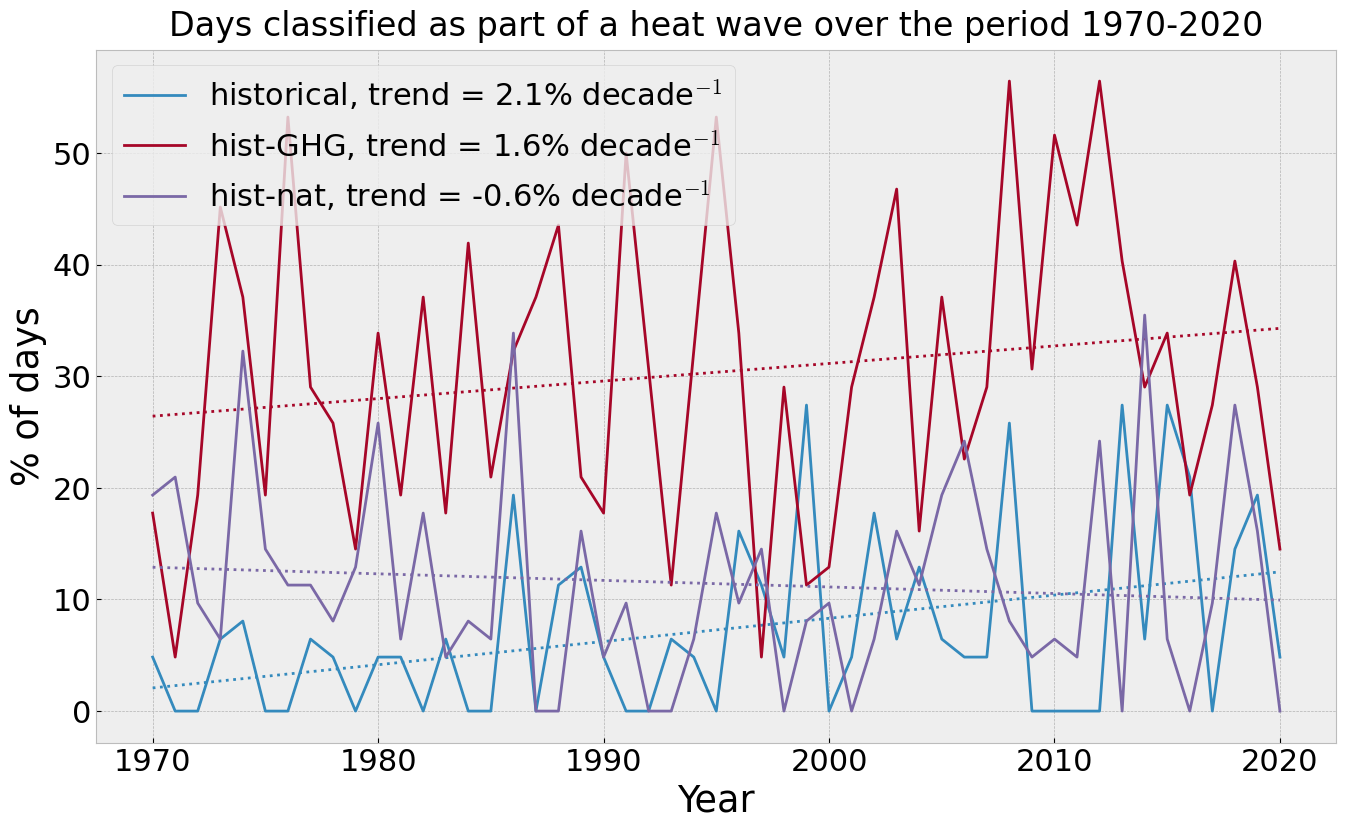

In [361]:
hw_days_hist = heat_wave_days[model + '_ssp_extended']
hw_days_GHG = heat_wave_days[model + '_hist-GHG']
hw_days_nat = heat_wave_days[model + '_hist-nat']
# hw_days_test.plot()
hw_percentage = 100*hw_days_test / 62
hw_percentage_GHG = 100*hw_days_GHG / 62
hw_percentage_nat = 100*hw_days_nat / 62
years = np.arange(1970, 2021, 1)

[hist_trend_slope, hist_trend_intercept] = np.polyfit(years, hw_days_hist, 1)
[GHG_trend_slope, GHG_trend_intercept] = np.polyfit(years, hw_days_GHG, 1)
[nat_trend_slope, nat_trend_intercept] = np.polyfit(years, hw_days_nat, 1)



hist_trend_func = np.poly1d(hist_trend)

plt.figure(figsize=(16,9))

plt.plot(
    hw_days_hist.year, 
    (100/62)*hw_days_hist, color='#348ABD', 
    label=f"historical, trend = {(100*10/62)*hist_trend_slope:0.1f}" + r"% decade$^{-1}$"
)

plt.plot(
    hw_days_hist.year, 
    (100/62)*(hist_trend_slope*years+hist_trend_intercept), 
    color='#348ABD', 
    ls=':'
)

plt.plot(
    hw_days_GHG.year, 
    (100/62)*hw_days_GHG, color='#A60628', 
    label=f"hist-GHG, trend = {(100*10/62)*GHG_trend_slope:0.1f}" + r"% decade$^{-1}$"
)
plt.plot(
    hw_days_GHG.year, 
    (100/62)*(GHG_trend_slope*years+GHG_trend_intercept), 
    color='#A60628', 
    ls=':'
)

plt.plot(
    hw_days_nat.year, 
    (100/62)*hw_days_nat, color='#7A68A6', 
    label=f"hist-nat, trend = {(100*10/62)*nat_trend_slope:0.1f}" + r"% decade$^{-1}$"
)

plt.plot(
    hw_days_nat.year, 
    (100/62)*(nat_trend_slope*years+nat_trend_intercept), 
    color='#7A68A6', 
    ls=':'
)

plt.title('Days classified as part of a heat wave over the period 1970-2020', fontsize=24, pad=10)
plt.ylabel('% of days')
plt.xlabel('Year')
plt.legend()
plt.show()

## Heat Wave Days Bar Chart

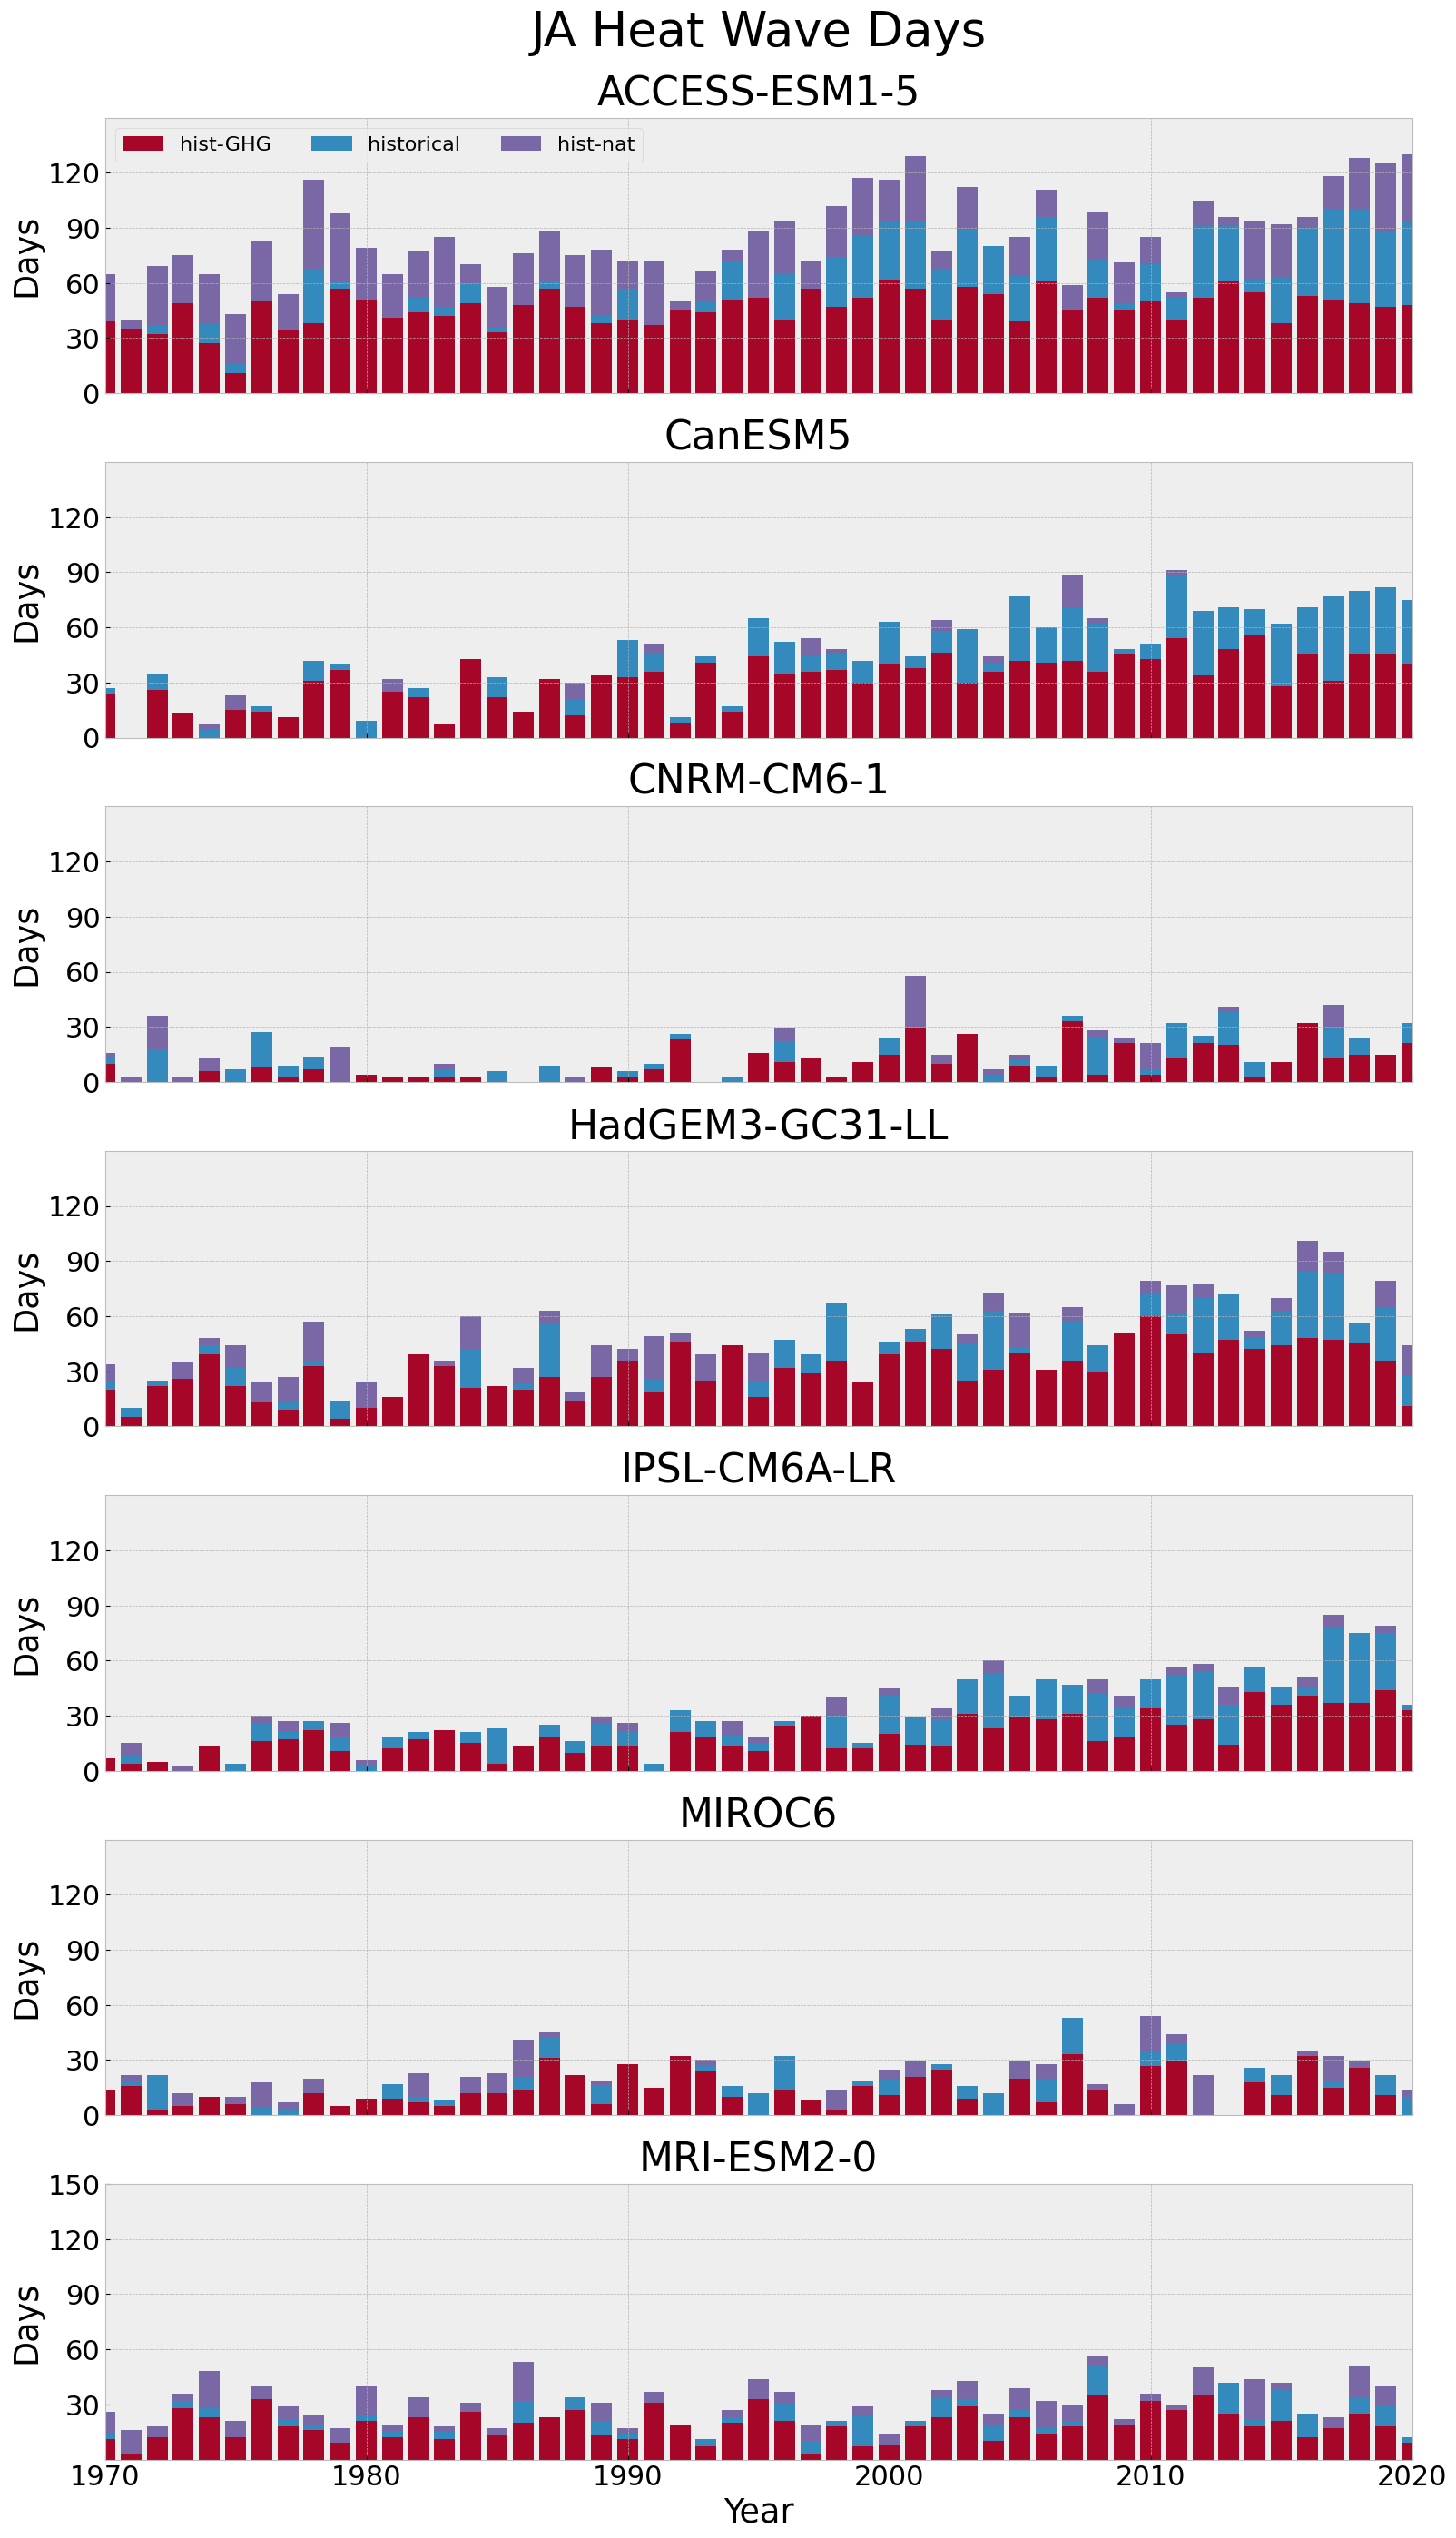

In [415]:
fig = plt.figure(figsize=(16,30))
gs = GridSpec(len(models_list), 1, figure=fig)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.91, hspace=0.25)
ax = []
fig.suptitle('JA Heat Wave Days', fontsize=38, y=0.95)
    
for index, _ in enumerate(models_list):    
    ax.append(fig.add_subplot(gs[index]))

for index, model in enumerate(models_list):

    hw_days_hist = heat_wave_days[model + '_ssp_extended']
    hw_days_GHG = heat_wave_days[model + '_hist-GHG']
    hw_days_nat = heat_wave_days[model + '_hist-nat']
    
    total_days = hw_days_hist + hw_days_GHG + hw_days_nat
    hist_percent = hw_days_hist/total_days
    GHG_percent = hw_days_GHG/total_days
    nat_percent = hw_days_nat/total_days
      
    # Percent of total days
    # ax[index].bar(years, GHG_percent, label='hist-GHG', color='#A60628')
    # ax[index].bar(years, hist_percent, bottom=GHG_percent, label='historical', color='#348ABD')
    # ax[index].bar(years, nat_percent, bottom=hist_percent + GHG_percent, label='hist-nat', color='#7A68A6')
        
    # Stacked bar plot
    # ax[index].bar(years, hw_days_hist, label='historical')
    ax[index].bar(years, hw_days_GHG, label='hist-GHG', color='#A60628')
    ax[index].bar(years, hw_days_hist, bottom=hw_days_GHG, label='historical', color='#348ABD')
    ax[index].bar(years, hw_days_nat, bottom=hw_days_hist + hw_days_GHG, label='hist-nat', color='#7A68A6')
    
    # Area plot
    # ax[index].fill_between(years, 0, hw_days_hist, label='historical', alpha=1)
    # ax[index].fill_between(years, hw_days_hist, hw_days_hist + hw_days_GHG, label='hist-GHG', alpha=1)
    # ax[index].fill_between(years, hw_days_hist + hw_days_GHG, hw_days_hist + hw_days_GHG + hw_days_nat, label='hist-nat', alpha=1)

    # Set labels and title
    ax[-1].set_xlabel('Year')
    ax[index].set_yticks(np.arange(0, 150, 30))
    ax[-1].yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='lower'))
    if index != len(models_list)-1:
        ax[index].set_xticklabels([])
    
    ax[index].set_ylabel('Days')
    ax[index].set_title(model, pad=10)

    # Add legend
    ax[0].legend(ncol=3, fontsize=16)
    
    ax[index].set_xlim(1970, 2020)
    ax[index].set_ylim(0, 150)
    
    ax[index].set_aspect('auto')
    
# Show the plot
plt.show()

# OLR Data

## OLR Maps

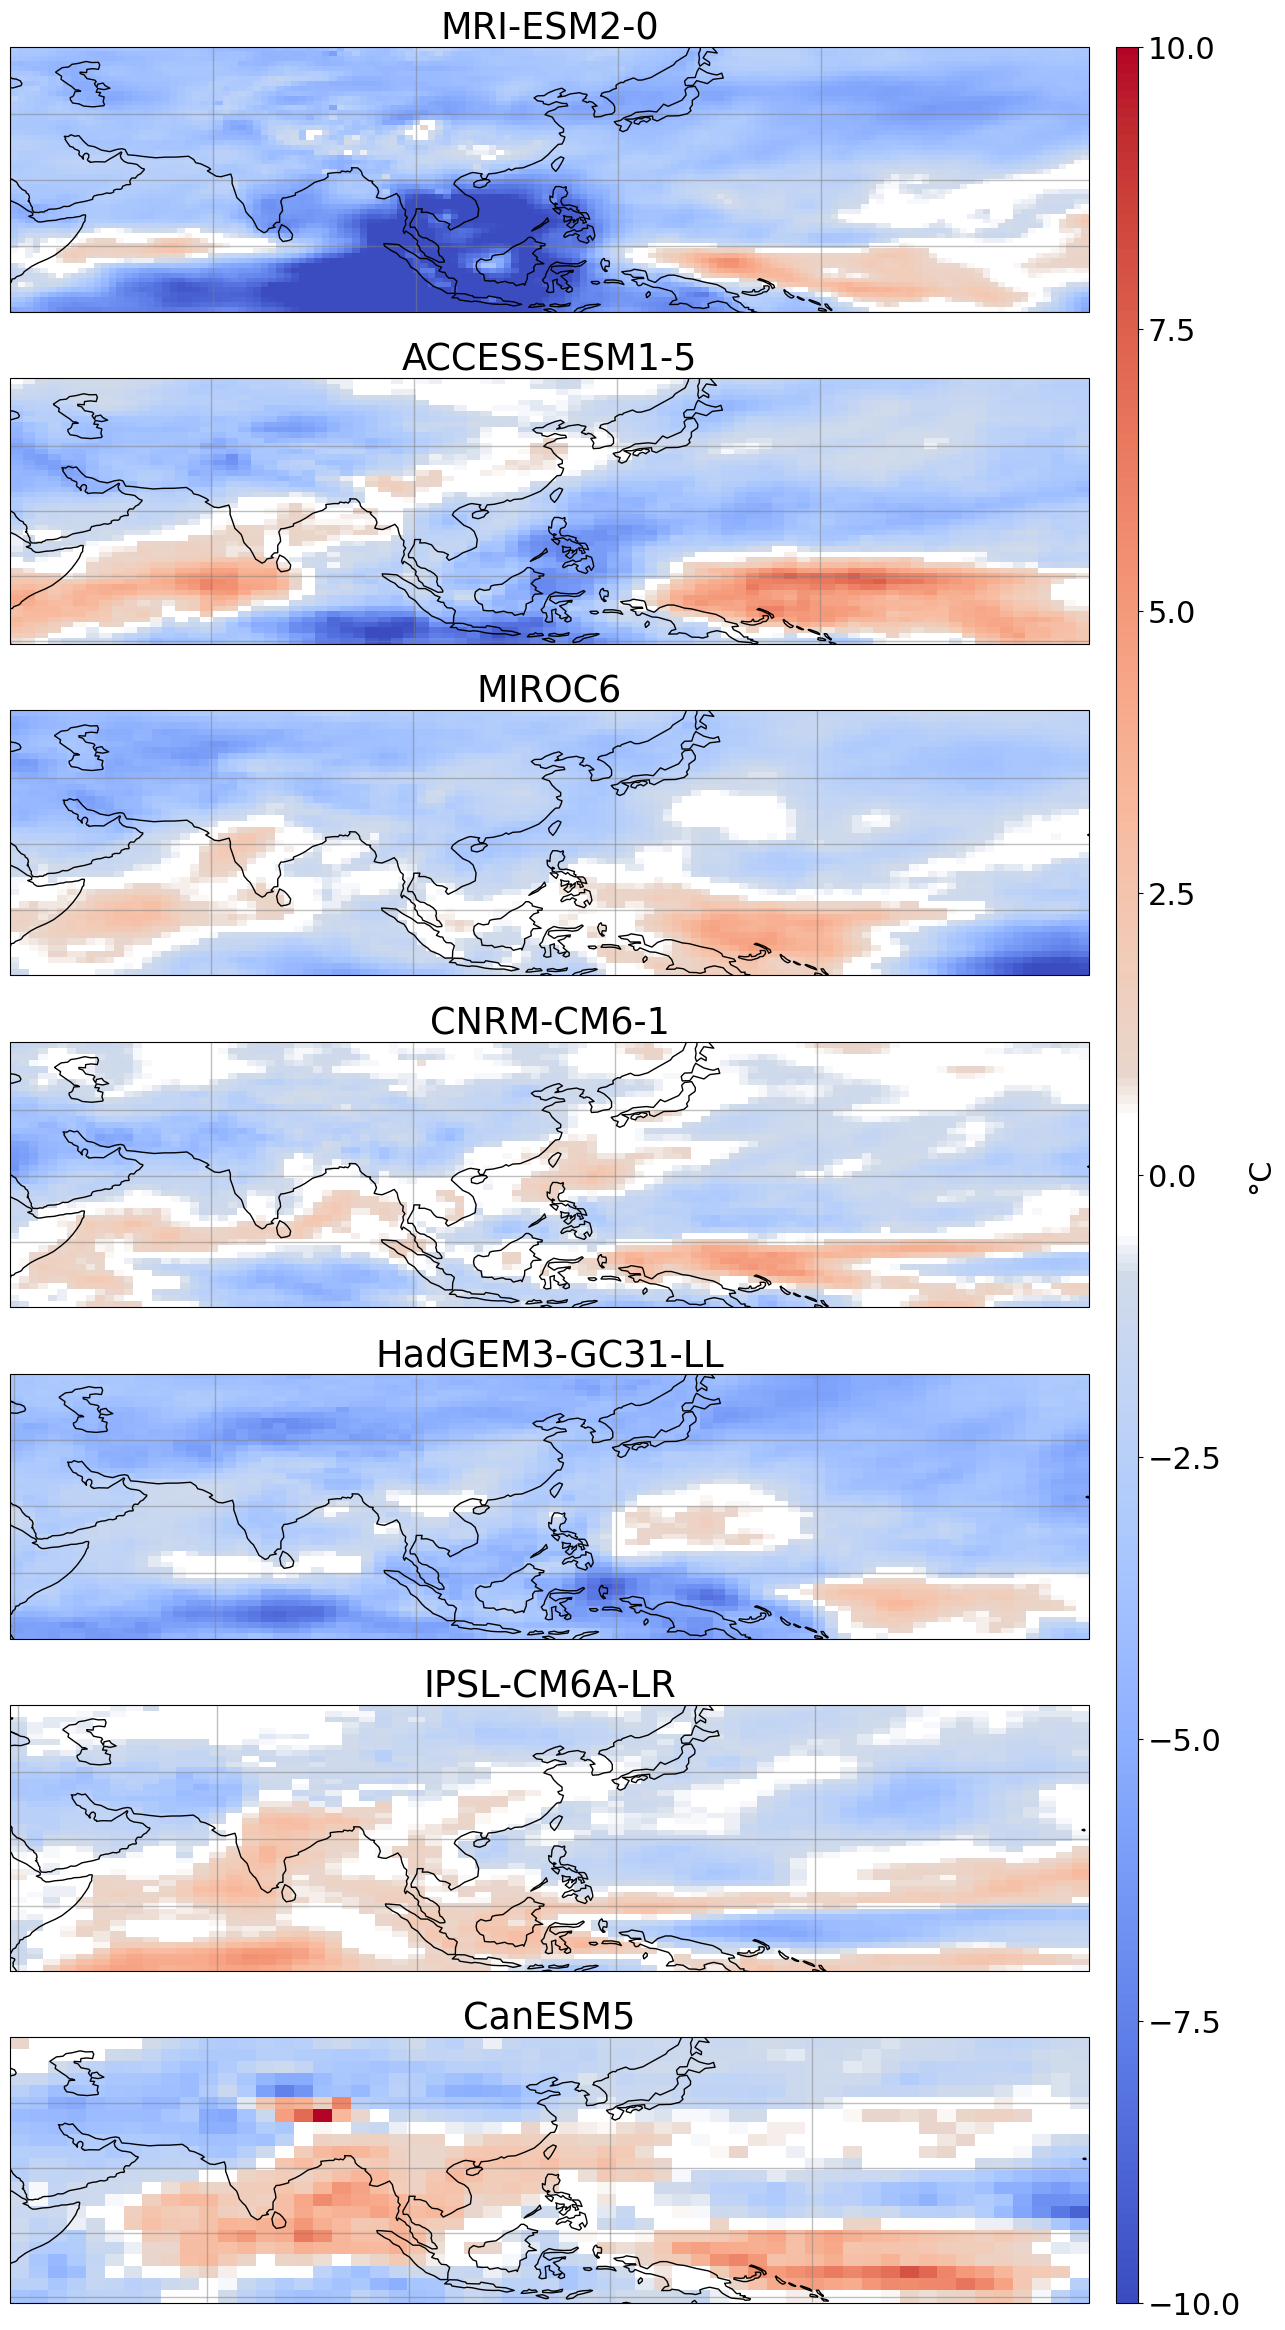

In [125]:
# models_list = ['ACCESS-ESM1-5', 'CanESM5', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
models_list = ['MRI-ESM2-0', 'ACCESS-ESM1-5', 'MIROC6', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'CanESM5']
variable = 'rlut'

korea_sst_region = dict(lat=slice(-10,50), lon=slice(40,200))

plt.style.use('default')
plt.rcParams.update({'font.size':22})
fig = plt.figure(figsize=(12,24))
gs = GridSpec(7,2, width_ratios=[100,2], figure=fig)
gs.update(left=0.01, right=0.95, bottom=0.01, top=0.95, wspace=0.05, hspace=0.25)

ax = []
ax.append(fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[3,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[4,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[5,0], projection=ccrs.PlateCarree(central_longitude=120)))
ax.append(fig.add_subplot(gs[6,0], projection=ccrs.PlateCarree(central_longitude=120)))

cbar_ax = fig.add_subplot(gs[:,-1])


for index, model in enumerate(models_list):
    
    ################### historical ###################
    # Load the historical data
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model)

    # Load the data
    file_name_historical = sorted(glob('./historical/compiled_' + variable + '_Amon_*.nc'))[0]
    [
        variable_historical, 
        frequency_historical, 
        model_name_historical, 
        experiment_historical, 
        variant_historical, 
        grid_historical, 
        period_historical
    ] = file_name_historical.split('/')[-1].split('.nc')[0].split('_')[1:]

    olr_data_historical = xr.open_dataset(file_name_historical)[variable]
    
    
    ################### ssp245 ###################
    # Load the ssp245 data
    file_name_ssp = sorted(glob('./ssp245/compiled_' + variable + '_Amon_*.nc'))[0]
    [
        variable_ssp, 
        frequency_ssp, 
        model_name_ssp, 
        experiment_ssp, 
        variant_ssp, 
        grid_ssp, 
        period_ssp
    ] = file_name_ssp.split('/')[-1].split('.nc')[0].split('_')[1:]

    olr_data_ssp = xr.open_dataset(file_name_ssp)[variable]
    
    # Concatenate together the historical data and the ssp data
    # olr_data_extended = xr.concat((olr_data_historical, olr_data_ssp), dim='time')
    period_extended = period_historical.split('-')[0] + '-' + period_ssp.split('-')[-1]
    
    ################### hist-GHG ###################
    # Set the directory
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/hist-GHG/')

    # Load the data
    file_name = sorted(glob('./compiled_*' + variable + '_Amon_*.nc'))[0]
    [
    variable_hist_GHG, 
    frequency_hist_GHG, 
    model_name_hist_GHG, 
    experiment_hist_GHG, 
    variant_hist_GHG, 
    grid_hist_GHG, 
    period_hist_GHG
    ] = file_name.split('/')[-1].split('.nc')[0].split('_')[1:]
    olr_data_hist_GHG = xr.open_dataset(file_name)[variable]
    
    
    ################### hist-nat ###################
    # Set the directory
    os.chdir('/home/disk/tc/pangulo/CMIP6/' + model + '/hist-nat/')

    # Load the data
    file_name = sorted(glob('./compiled_*' + variable + '_Amon_*.nc'))[0]
    [
    variable_hist_nat, 
    frequency_hist_nat, 
    model_name_hist_nat, 
    experiment_hist_nat, 
    variant_hist_nat, 
    grid_hist_nat, 
    period_hist_nat
    ] = file_name.split('/')[-1].split('.nc')[0].split('_')[1:]
    olr_data_hist_nat = xr.open_dataset(file_name)[variable]
    
    # Subset to Korean region
    olr_korea_historical = olr_data_historical.sel(korea_sst_region)
    olr_korea_ssp = olr_data_ssp.sel(korea_sst_region)
    olr_korea_hist_GHG = olr_data_hist_GHG.sel(korea_sst_region)
    olr_korea_hist_nat = olr_data_hist_nat.sel(korea_sst_region)
    
    # Concatenate historical and ssp245 to get extended
    olr_korea_extended = xr.concat((olr_korea_historical, olr_korea_ssp), dim='time')
    
    # Calculate OLR differences
    olr_difference_hist_nat = olr_korea_extended - olr_korea_hist_nat
    twenty_year_mean_olr_hist_nat = olr_difference_hist_nat.sel(time=slice('2000','2020')).mean(dim='time')

    olr_difference_GHG_nat = olr_korea_hist_GHG - olr_korea_hist_nat
    twenty_year_mean_olr_GHG_nat = olr_difference_GHG_nat.sel(time=slice('2000','2020')).mean(dim='time')
    
    olr_difference_hist_GHG = olr_korea_extended - olr_korea_hist_GHG
    twenty_year_mean_olr_hist_GHG = olr_difference_hist_GHG.sel(time=slice('2000','2020')).mean(dim='time')
    
    cmap_modified = mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05)
    # cmap_modified.set_bad(color='beige')
    ax[index].set_title(model)
    im = ax[index].pcolormesh(
        twenty_year_mean_olr_hist_GHG.lon,
        twenty_year_mean_olr_hist_GHG.lat,
        twenty_year_mean_olr_hist_GHG,
        transform=ccrs.PlateCarree(),
        cmap=cmap_modified,
        norm=mcolors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10),
        # levels=np.arange(-0.5, 3, 0.1),
        # extend='both'
    )

    ax[index].set_aspect('auto')

    gl = ax[index].gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="-"
    )
    
    gl.right_labels=False
    gl.left_labels=False
    gl.xlocator = mticker.FixedLocator(np.arange(40,200,30))
    gl.xformatter = LongitudeFormatter()
    gl.ylocator = mticker.FixedLocator(np.arange(-10,50,15))
    gl.yformatter = LatitudeFormatter()

    ax[index].add_feature(cfeature.COASTLINE, zorder=15)

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('°C')
plt.show()

# Miscellaneous

## Native SST grid access

In [ ]:
#     ### Average data over Korea ####
#     if model == 'ACCESS-ESM1-5' or model == 'CanESM5' or model == 'HadGEM3-GC31-LL':
#         # historical
#         [korea_j, korea_i] = np.where(
#              (temperature_data_historical.latitude.values >= korea_south)
#             *(temperature_data_historical.latitude.values <= korea_north)
#             *(temperature_data_historical.longitude.values >= korea_west)
#             *(temperature_data_historical.longitude.values <= korea_east)
#         )

#         temperature_korea_historical = temperature_data_historical.isel(
#             i=slice(korea_i.min(), korea_i.max()), 
#             j=slice(korea_j.min(), korea_j.max())
#         ).mean(dim=['i','j'])
        
#         # ssp245
#         [korea_j, korea_i] = np.where(
#              (temperature_data_ssp.latitude.values >= korea_south)
#             *(temperature_data_ssp.latitude.values <= korea_north)
#             *(temperature_data_ssp.longitude.values >= korea_west)
#             *(temperature_data_ssp.longitude.values <= korea_east)
#         )

#         temperature_korea_ssp = temperature_data_ssp.isel(
#             i=slice(korea_i.min(), korea_i.max()), 
#             j=slice(korea_j.min(), korea_j.max())
#         ).mean(dim=['i','j'])
        
#         # hist-GHG
#         [korea_j, korea_i] = np.where(
#             (temperature_data_hist_GHG.latitude.values >= korea_south
#             )*(temperature_data_hist_GHG.latitude.values <= korea_north)
#             *(temperature_data_hist_GHG.longitude.values >= korea_west)
#             *(temperature_data_hist_GHG.longitude.values <= korea_east)
#         )
#         temperature_korea_hist_GHG = temperature_data_hist_GHG.isel(
#             i=slice(korea_i.min(), korea_i.max()),
#             j=slice(korea_j.min(), korea_j.max())
#         ).mean(dim=['i', 'j'])
        
#         # hist-nat
#         [korea_j, korea_i] = np.where(
#             (temperature_data_hist_nat.latitude.values >= korea_south
#             )*(temperature_data_hist_nat.latitude.values <= korea_north)
#             *(temperature_data_hist_nat.longitude.values >= korea_west)
#             *(temperature_data_hist_nat.longitude.values <= korea_east)
#         )
#         temperature_korea_hist_nat = temperature_data_hist_nat.isel(
#             i=slice(korea_i.min(), korea_i.max()),
#             j=slice(korea_j.min(), korea_j.max())
#         ).mean(dim=['i', 'j'])
        
#     elif model == 'CNRM-CM6-1':
#         # historical
#         korea_region = dict(lat=slice(korea_south,korea_north), lon=slice(korea_west, korea_east))
#         temperature_korea_historical = temperature_data_historical.sel(korea_region).mean(dim=['lat', 'lon'])
        
#         # ssp
#         [korea_y, korea_x] =  np.where(
#              (temperature_data_ssp.lat.values  >= korea_south)
#             *(temperature_data_ssp.lat.values  <= korea_north)
#             *(temperature_data_ssp.lon.values >= korea_west)
#             *(temperature_data_ssp.lon.values <= korea_east)
#         )
#         temperature_korea_ssp = temperature_data_ssp.isel(
#             x=slice(korea_x.min(), korea_x.max()), 
#             y=slice(korea_y.min(), korea_y.max())
#         ).mean(dim=['x','y'])
        
#         # hist-GHG
#         korea_region = dict(lat=slice(korea_south,korea_north), lon=slice(korea_west, korea_east))
#         temperature_korea_hist_GHG = temperature_data_hist_GHG.sel(korea_region).mean(dim=['lat', 'lon'])
        
#         # hist-nat
#         korea_region = dict(lat=slice(korea_south,korea_north), lon=slice(korea_west, korea_east))
#         temperature_korea_hist_nat = temperature_data_hist_nat.sel(korea_region).mean(dim=['lat', 'lon'])
        
#     elif model == 'IPSL-CM6A-LR':
#         # historical
#         [korea_y, korea_x] =  np.where(
#              (temperature_data_historical.latitude.values  >= korea_south)
#             *(temperature_data_historical.latitude.values  <= korea_north)
#             *(temperature_data_historical.longitude.values >= korea_west)
#             *(temperature_data_historical.longitude.values <= korea_east)
#         )
#         temperature_korea_historical = temperature_data_historical.isel(
#             x=slice(korea_x.min(), korea_x.max()), 
#             y=slice(korea_y.min(), korea_y.max())
#         ).mean(dim=['x','y'])
        
#         # ssp
#         [korea_y, korea_x] =  np.where(
#              (temperature_data_ssp.latitude.values  >= korea_south)
#             *(temperature_data_ssp.latitude.values  <= korea_north)
#             *(temperature_data_ssp.longitude.values >= korea_west)
#             *(temperature_data_ssp.longitude.values <= korea_east)
#         )
#         temperature_korea_ssp = temperature_data_ssp.isel(
#             x=slice(korea_x.min(), korea_x.max()), 
#             y=slice(korea_y.min(), korea_y.max())
#         ).mean(dim=['x','y'])
        
#         # hist-GHG
#         [korea_y, korea_x] =  np.where(
#              (temperature_data_hist_GHG.latitude.values  >= korea_south)
#             *(temperature_data_hist_GHG.latitude.values  <= korea_north)
#             *(temperature_data_hist_GHG.longitude.values >= korea_west)
#             *(temperature_data_hist_GHG.longitude.values <= korea_east)
#         )
#         temperature_korea_hist_GHG = temperature_data_hist_GHG.isel(
#             x=slice(korea_x.min(), korea_x.max()), 
#             y=slice(korea_y.min(), korea_y.max())
#         ).mean(dim=['x','y'])
        
#         # hist-nat
#         [korea_y, korea_x] =  np.where(
#              (temperature_data_hist_nat.latitude.values  >= korea_south)
#             *(temperature_data_hist_nat.latitude.values  <= korea_north)
#             *(temperature_data_hist_nat.longitude.values >= korea_west)
#             *(temperature_data_hist_nat.longitude.values <= korea_east)
#         )
#         temperature_korea_hist_nat = temperature_data_hist_nat.isel(
#             x=slice(korea_x.min(), korea_x.max()), 
#             y=slice(korea_y.min(), korea_y.max())
#         ).mean(dim=['x','y'])   
        
#     elif model == 'MIROC6':
#         # historical
#         korea_region = dict(latitude=slice(korea_south,korea_north), longitude=slice(korea_west-60, korea_east-60))
#         temperature_korea_historical = temperature_data_historical.sel(korea_region).mean(dim=['latitude', 'longitude'])
        
#         # ssp
#         korea_region = dict(latitude=slice(korea_south,korea_north), longitude=slice(korea_west, korea_east))
#         temperature_korea_ssp = temperature_data_ssp.sel(korea_region).mean(dim=['latitude', 'longitude'])
        
#         # hist-GHG
#         [korea_y, korea_x] =  np.where(
#              (temperature_data_hist_GHG.latitude.values >= korea_south)
#             *(temperature_data_hist_GHG.latitude.values <= korea_north)
#             *(temperature_data_hist_GHG.longitude.values >= korea_west)
#             *(temperature_data_hist_GHG.longitude.values <= korea_east)
#         )
#         temperature_korea_hist_GHG = temperature_data_hist_GHG.isel(
#             x=slice(korea_x.min(), korea_x.max()),
#             y=slice(korea_y.min(), korea_y.max()) 
#         ).mean(dim=['x','y'])

#         # hist-nat
#         [korea_y, korea_x] =  np.where(
#              (temperature_data_hist_nat.latitude.values >= korea_south)
#             *(temperature_data_hist_nat.latitude.values <= korea_north)
#             *(temperature_data_hist_nat.longitude.values >= korea_west)
#             *(temperature_data_hist_nat.longitude.values <= korea_east)
#         )
#         temperature_korea_hist_nat = temperature_data_hist_nat.isel(
#             x=slice(korea_x.min(), korea_x.max()),
#             y=slice(korea_y.min(), korea_y.max())
#         ).mean(dim=['x','y'])
        
#     elif model == 'MRI-ESM2-0':
#         # historical
#         korea_region = dict(latitude=slice(korea_south,korea_north), longitude=slice(korea_west, korea_east))
#         temperature_korea_historical = temperature_data_historical.sel(korea_region).mean(dim=['latitude', 'longitude'])
        
#         # ssp
#         korea_region = dict(latitude=slice(korea_south,korea_north), longitude=slice(korea_west, korea_east))
#         temperature_korea_ssp = temperature_data_ssp.sel(korea_region).mean(dim=['latitude', 'longitude'])
        
#         # hist-GHG
#         korea_region = dict(latitude=slice(korea_south,korea_north), longitude=slice(korea_west, korea_east))
#         temperature_korea_hist_GHG = temperature_data_hist_GHG.sel(korea_region).mean(dim=['latitude', 'longitude'])
        
#         # hist-nat
#         korea_region = dict(latitude=slice(korea_south,korea_north), longitude=slice(korea_west, korea_east))
#         temperature_korea_hist_nat = temperature_data_hist_nat.sel(korea_region).mean(dim=['latitude', 'longitude'])


In [52]:
def modified_colormap(colormap, central_color, central_width, blend_strength):    
    '''
    This function modifies a colormap to set the central region to be white. 
    Within the region specified by the 'width' parameter, the colormap is blended towards white using a linspace.
    
    Parameters:
        colormap (str): The name of an existing matplotlib colormap
        central_width (float): The width of the region to be set to white
        blend_strength (float): The width of the regions to be blended to white

    Returns:
        modified_colormap (matplotlib.colors.LinearSegmentedColormap): The modified colormap
    
    '''
    # Import libraries
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import colors as mcolors
    
    try:
        c = mcolors.cnames[central_color]
    except: 
        raise KeyError('Not a matplotlib named color')
        
    central_color = list(mcolors.to_rgba(central_color))
    
    # Raise an error if the width is not between 0 and 1
    if ((central_width < 0)+(central_width > 1)):
        raise ValueError('Central width must be in range [0, 1]')
    elif ((blend_strength < 0) + (blend_strength > 1)):
        raise ValueError('Blend strength must be in range [0, 1]')
    
    # Convert the widths to the range [0, 127]
    else:             
        central_width = int(127*central_width)
        blend_strength = int(blend_strength*(127-central_width))

    # Get the colormap values
    original_colormap = plt.cm.get_cmap(colormap)
    newcolors = original_colormap(np.linspace(0, 1, 256))
    
    # Get the value of the colormap 'width' values left of the center, and blend from that value to white at the center
    newcolors[128-central_width-blend_strength:128-central_width, :] = np.linspace(
        newcolors[128-central_width-blend_strength, :], 
        central_color, 
        blend_strength
    )
    
    newcolors[128-central_width:128+central_width, :] = central_color
    
    # Get the value of the colormap 'width' values right of the center, and blend from white at the center to that value
    newcolors[128+central_width:128+central_width+blend_strength, :] = np.linspace(
        central_color,
        newcolors[128+central_width+blend_strength, :], 
        blend_strength
    )
    
    # Create a new colormap object from the modified map
    modified_colormap = mcolors.LinearSegmentedColormap.from_list(colormap+'_modified', newcolors)
    
    return modified_colormap

## Test HW Statisics

In [916]:
data_length = 500
time = np.arange(1, data_length+1, 1)
data = np.floor(50*np.random.rand(data_length)) + np.random.rand()*np.arange(data_length)
data_reference = 0+np.floor(50*np.random.rand(data_length)) + np.random.rand()*np.arange(data_length)

data_array = xr.DataArray(data,
                         dims=['time'],
                         coords={'time':time})

data_reference_array = xr.DataArray(data_reference,
                         dims=['time'],
                         coords={'time':time})

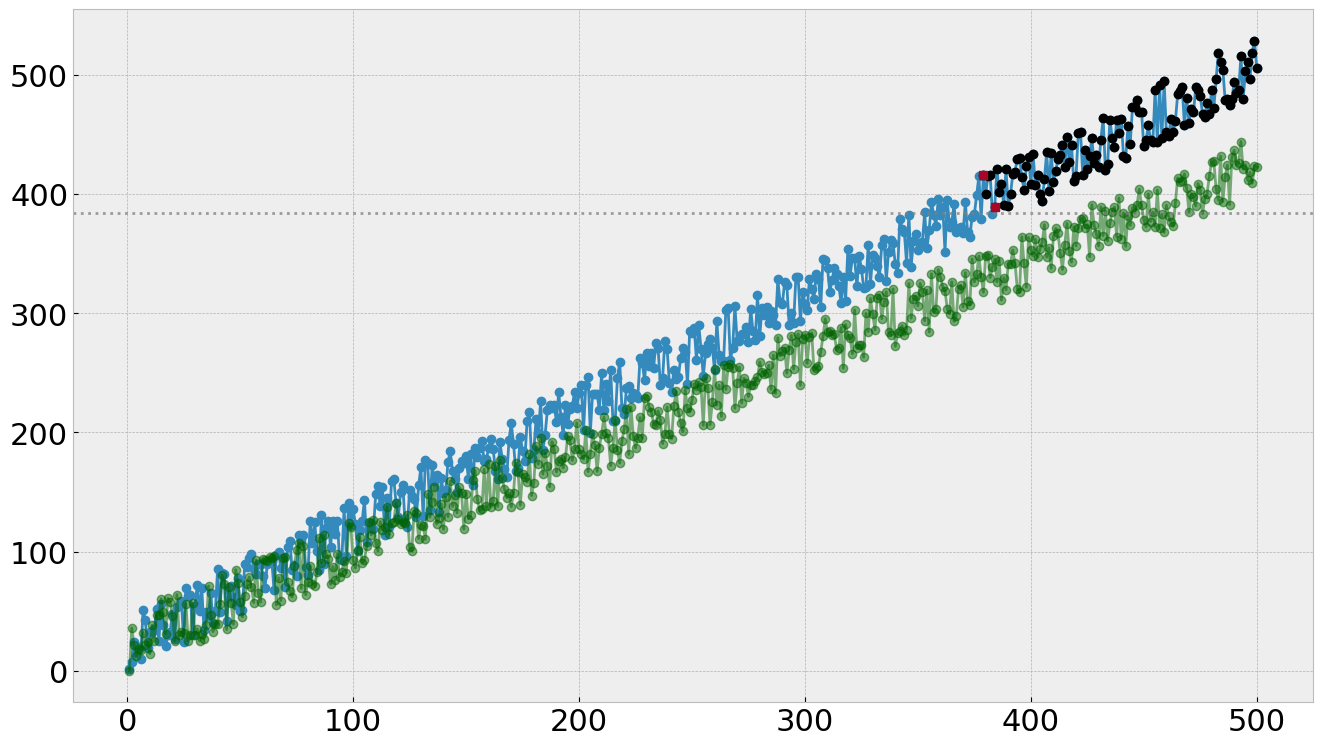

In [917]:
T_threshold = data_reference_array.quantile(0.9)
dates_threshold = 3

center_dates = data_array.where(data_array.rolling(time=dates_threshold, center=True).min() >= T_threshold).dropna(dim='time')

if center_dates.size != 0:
    time_range_data_list = []

    for central_index in center_dates.time:
        start_index = central_index - dates_threshold//2
        end_index = central_index + dates_threshold//2

        # Select the data within the specified time range
        time_range_data = data_array.sel(time=slice(start_index, end_index)).time

        # Append the time range data to the list
        time_range_data_list.append(time_range_data)

    # Combine the time range data from all central indices into a single DataArray along a new dimension 'central_index'
    heat_wave_days = xr.concat(time_range_data_list, dim='time').dropna(dim='time').drop_duplicates(dim='time')
    
    coord_diff = heat_wave_days['time'].diff(dim='time')
    heat_wave_start = xr.concat((heat_wave_days[0], heat_wave_days.where((coord_diff > 1) | (coord_diff.isnull()), drop=True)), dim='time')
    coord_diff = xr.concat((xr.DataArray([1], dims='time', coords={'time':[1]}),heat_wave_days['time'].diff(dim='time')), dim='time')
    labels = (coord_diff > 1).cumsum(dim='time')
    heat_wave_lengths = heat_wave_days.groupby(labels).count(dim='time')

    plt.figure(figsize=(16,9))
    plt.plot(data_array.time, data_array, marker='o')
    # plt.plot(data_array.time, data_reference_array, marker='o', color='lightgreen')
    plt.plot(data_array.time, data_reference_array.rolling(time=1).mean(), marker='o', color='darkgreen', alpha=0.5)
    plt.plot(heat_wave_days.time, data_array.sel(time=heat_wave_days), marker='o', color='k', ls='')
    plt.plot(heat_wave_start, data_array.sel(time=heat_wave_start), ls='', marker='s')
    plt.axhline(y=T_threshold, color='gray', ls=':', alpha=0.75)
    plt.gca().set_aspect('auto')
    # plt.xlim(420,480)
    plt.show()
    
else:
    print("No heat waves")